The goal of this notebook is to preprocess relevant information from the GDC portal (using UCSC Xena) to use in Deciphering_CIMP_Analysis
Data can be downloaded directly from the UCSC Xena website

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import xenaPython as xena
import re
import os
from collections import Counter
import matplotlib.pyplot as plt
import csv
from tqdm.notebook import trange, tqdm
import time
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import seaborn as sns
from statsmodels.stats.multitest import multipletests

C:\Users\josep\Anaconda3\lib\site-packages\xenaPython\__init__.py:110: FutureWarning: Possible nested set at position 7
  re.sub(r"^[^[]+[[]([^]]*)[]].*$", r"\1", query, flags=re.DOTALL))


# Clinical mat preprocessing

Preprocessing the clinical matrices is somewhat complicated in the sense that they are not systematically named; this script by no means claims to take into account all cases but works for all studied cancer types

In [2]:
# clin_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\clinical_mat"
survival_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\survival"
info_dir = "N:\\data\\projects\\Josephine_CIMP\\CIMP_unsupervised_cancer\\filtered_illumina_TCGA"

In [ ]:
clin_files = os.listdir(info_dir)
survival_files = os.listdir(survival_dir)

In [ ]:
cancer_to_keep = np.unique([clin_files[i].split(".")[0].split("_")[0] for i in range(len(clin_files))])

In [5]:
cancer_to_keep

array(['ACC', 'BLCA', 'BRCA', 'CESC', 'COAD', 'COADREAD', 'ESCA', 'GBM',
       'HNSC', 'KIRC', 'KIRP', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC',
       'MESO', 'PAAD', 'PCPG', 'PRAD', 'READ', 'SARC', 'SKCM', 'STAD',
       'THCA', 'THYM', 'UCEC'], dtype='<U8')

In [54]:
clinpd = pd.read_csv(os.path.join(clin_dir,clin_files[3]),sep="\t")

In [60]:
for i,cancer in enumerate(tqdm(cancer_to_keep)):
    print(cancer,i)
    clinpd = pd.read_csv(os.path.join(clin_dir,clin_files[i]),sep="\t")
    if cancer=="PRAD":
        clinical_matrix = clinpd.set_index("submitter_id.samples")[["clinical_T","days_to_birth.demographic","gender.demographic"]]
        clinical_matrix.columns = ['stage', 'age', 'gender']
    elif "pathologic_stage" in list(clinpd.columns):
        clinical_matrix = clinpd.set_index("sampleID")[["pathologic_stage","days_to_birth","gender"]]
        clinical_matrix.columns = ['stage', 'age', 'gender']
    elif "pathological_stage" in list(clinpd.columns):
        clinical_matrix = clinpd.set_index("sampleID")[["pathological_stage","days_to_birth","gender"]]   
        clinical_matrix.columns = ['stage', 'age', 'gender']
    elif "clinical_stage" in list(clinpd.columns):
        if "sampleID" in list(clinpd.columns):
            clinical_matrix = clinpd.set_index("sampleID")[["clinical_stage","days_to_birth","gender"]] 
        else:
            clinical_matrix = clinpd.set_index("submitter_id.samples")[["clinical_stage","days_to_birth.demographic","gender.demographic"]]
        clinical_matrix.columns = ['stage', 'age', 'gender']
    elif "tumor_stage.diagnoses" in list(clinpd.columns):
        if "sampleID" in list(clinpd.columns):
            clinical_matrix = clinpd.set_index("sampleID")[["tumor_stage.diagnoses","days_to_birth","gender"]] 
        else:
            clinical_matrix = clinpd.set_index("submitter_id.samples")[["tumor_stage.diagnoses","days_to_birth.demographic","gender.demographic"]]
        clinical_matrix.columns = ['stage', 'age', 'gender']
    else:
        clinical_matrix = clinpd.set_index("sampleID")[["days_to_birth","gender"]]
        clinical_matrix.columns = ['age', 'gender']
        
    survival_matrix = pd.read_csv(os.path.join(survival_dir,survival_files[i]),sep="\t")
    if "sample" in list(survival_matrix.columns):
        survival_matrix = survival_matrix.set_index("sample")[["OS","OS.time"]]
    else:
        survival_matrix = survival_matrix.set_index("xena_sample")[["OS","OS.time"]]
    full_clin_matrix = pd.concat([clinical_matrix,survival_matrix],axis=1)
    common_pat = survival_matrix.index.intersection(clinical_matrix.index)
    print("Number of patients : ",len(common_pat))
    clinical_matrix = clinical_matrix.loc[common_pat]
    survival_matrix = survival_matrix.loc[common_pat]
    full_clin_matrix.index = [full_clin_matrix.index[i][:15] for i in range(len(full_clin_matrix.index))]
    full_clin_matrix.to_csv(os.path.join(info_dir,cancer+"_clin_mat.csv"))

CESC 0
Number of patients :  304
LAML 1
Number of patients :  626
PCPG 2
Number of patients :  189
PRAD 3
Number of patients :  623
SARC 4
Number of patients :  287
THYM 5
Number of patients :  138
UCEC 6
Number of patients :  590



In [55]:
for tissue in tqdm(tissue_types):
    tissue_full_df = []
    for i in tqdm(range(3)):
        df = pd.read_csv(os.path.join(geo_normal_dir,tissue+"_normal_pat_"+str(i+1)+".csv"))
        df.index = ["patient_"+str(i+1)]
        if len(tissue_full_df)==0:
            tissue_full_df = df
        else:
            tissue_full_df = pd.concat([tissue_full_df,df])
        tissue_full_df.to_csv(os.path.join(geo_normal_dir,tissue+"_normal_full.csv"))

# Methylation preprocessing

There are 4 steps to methylation preprocessing that we will go through: 
1. Filter out NA, keep only CpG Islands (+shores & shelves), filter out X and Y chromosome probes
2. Keep only most variable probes 
3. Deconvolute methylation to keep only the cancerous cells signal (ie correct for purity)
4. Remove potentially age-related probes (shared across at least two tissues)

In [69]:
info_dir = "N:\\data\\projects\\Josephine_CIMP\\CIMP_unsupervised_cancer\\filtered_illumina_TCGA"
clin_data_pc = {}
for cancer in tqdm(cancer_to_keep):
    clin_data_pc[cancer] = pd.read_csv(os.path.join(info_dir,cancer+"_clin_mat.csv"))
    clin_data_pc[cancer] = clin_data_pc[cancer].set_index("Unnamed: 0")   

## Step 0. Download data

In [5]:
raw_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\meth450k_raw"
cancer_to_keep = os.listdir(raw_dir)
cancer_to_keep = [cancer.split(".")[0].split("-")[1] for cancer in cancer_to_keep]

In [6]:
meth_raw_pc = {}
for cancer in tqdm(cancer_to_keep):
    meth_data_450k = pd.read_csv(os.path.join(raw_dir,"TCGA-"+cancer+".methylation450.tsv.gz"),sep="\t")
    meth_data_450k = meth_data_450k.set_index("Composite Element REF")
    meth_data_csv_nona = meth_data_450k.dropna(how="any").T
    meth_data_csv_nona.index = [pat[:15] for pat in np.array(meth_data_450k.columns)]
    meth_raw_pc[cancer] = meth_data_csv_nona 

In [7]:
### to concatenate ESTIMATE purity files
# First, take separate ESTIMATE purity estimations and concatenate them so that they resemble the 
# downloaded CPE purity estimations 
estimate_purity_dir = "N:\\data\\projects\\Agnieszka_Tumor_heterogeneity\\data\\Estimate_purity"
cancer_estimate_purity = ["ESCA", "LAML", "MESO", "PAAD", "PCPG", "SARC", "STAD", "THYM"]
full_purity_df = []
for cancer in tqdm(cancer_estimate_purity):
    purity_cancer = pd.read_csv(os.path.join(estimate_purity_dir,"TCGA_"+cancer+"_estimate_score.txt"),sep="\t")
    purity_cancer = purity_cancer.drop(0).drop("Unnamed: 1",axis=1).set_index("#1.2").T.set_index("NAME")
    purity_cancer.index = purity_cancer.index.str.replace(".","-")
    purity_cancer["cancer_type"]=[cancer]*purity_cancer.shape[0]
    if len(full_purity_df)==0:
        full_purity_df = purity_cancer
    else:
        full_purity_df = pd.concat([full_purity_df,purity_cancer])
full_purity_df.to_csv("N:\\data\\projects\\Josephine_CIMP\\CIMP_unsupervised_cancer\\auxiliary_data\\tumor_purity_ESTIMATE.csv")

In [8]:
# download both the CPE purity data and ESTIMATE data for those that do not have CPE
purity = pd.read_csv("N:\\data\\projects\\Josephine_CIMP\\CIMP_unsupervised_cancer\\auxiliary_data\\tumor_purity.csv")
estimate_purity = pd.read_csv("N:\\data\\projects\\Josephine_CIMP\\CIMP_unsupervised_cancer\\auxiliary_data\\tumor_purity_ESTIMATE.csv").set_index("NAME")

In [9]:
# Systematically name the patients
purity["Sample.ID"] = np.array([purity["Sample.ID"].values[i][:-1] for i in range (len(purity["Sample.ID"].values))])
purity = purity.set_index("Sample.ID")

# Sometimes there is no CPE information; we replace it by ESTIMATE (and IHC for 1 patient that has none)
purity["CPE"] = purity["CPE"].str.replace(",",".").astype(float)
ind_na = np.where(purity["CPE"].isna())[0]
purity.iloc[ind_na,-1] = purity.iloc[ind_na,-5].str.replace(",",".").astype(float)
ind_na_double = np.where(purity["CPE"].isna())[0]
purity.iloc[ind_na_double,-1] = purity.iloc[ind_na_double,-2].str.replace(",",".").astype(float)

purity = purity[~purity.index.duplicated(keep='first')]

In [10]:
Counter(purity["Cancer.type"].values.ravel())

Counter({'ACC': 92,
         'BLCA': 413,
         'BRCA': 1108,
         'CESC': 310,
         'COAD': 464,
         'GBM': 619,
         'HNSC': 530,
         'KICH': 113,
         'KIRC': 538,
         'KIRP': 292,
         'LGG': 530,
         'LIHC': 379,
         'LUAD': 525,
         'LUSC': 511,
         'OV': 606,
         'PRAD': 499,
         'READ': 173,
         'SKCM': 474,
         'THCA': 515,
         'UCEC': 549,
         'UCS': 57})

## Step 1. Filter out NA, CGI, X/Y chr

### Get cpg mappings through GEO database

In [11]:
Meth45k = []
#with open("/mnt/data/projects/Josephine_CIMP/CIMP_unsupervised_cancer/methylation_annotation_Illumina/GPL13534_HumanMethylation450_15017482_v.1.1.csv") as csvfile:
# with open("N:\\data\\projects\\Josephine_CIMP\\CIMP_unsupervised_cancer\\methylation_annotation_Illumina\\GPL13534_HumanMethylation450_15017482_v.1.1.csv") as csvfile:
with open("GPL13534_HumanMethylation450_15017482_v.1.1.csv") as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        Meth45k.append(row)

In [12]:
colnames_45k = Meth45k[7]
methylation_val_45k = Meth45k[8:]
Meth45k_df = pd.DataFrame(methylation_val_45k,columns=colnames_45k)

In [13]:
Meth45k_df = Meth45k_df.set_index("IlmnID")

In [14]:
Counter(Meth45k_df['Relation_to_UCSC_CpG_Island'])

Counter({'': 176112,
         'N_Shore': 62870,
         'S_Shelf': 22300,
         'Island': 150254,
         'S_Shore': 49197,
         'N_Shelf': 24844,
         None: 851})

### CpG Islands only

In [15]:
CIMP_list = ["N_Shore","S_Shelf","Island","S_Shore","N_Shelf"]

In [16]:
cpg_island_45k=np.array(Meth45k_df[Meth45k_df["Relation_to_UCSC_CpG_Island"].isin(CIMP_list)].index)

### Filter out chr X/Y positions

To avoid clustering by gender and to avoid artificial hypermethylation created by gender (eg X chromosome inactivation), we remove the Cpg ids linked to the X/Y chromosome

In [17]:
not_chrX_cpg= np.array(Meth45k_df.iloc[np.where(np.invert(Meth45k_df["CHR"].values=="X"))[0]].index)
not_chrY_cpg= np.array(Meth45k_df.iloc[np.where(np.invert(Meth45k_df["CHR"].values=="Y"))[0]].index)

### First filter

In [18]:
first_filter_count = []
filtered_meth_data_pc = {}
for cancer in tqdm(cancer_to_keep):
    print(cancer)
    meth_data_csv_nona = meth_raw_pc[cancer]
    filtered_meth_data = meth_data_csv_nona[meth_data_csv_nona.columns.intersection(cpg_island_45k)]
    filtered_meth_data = filtered_meth_data[filtered_meth_data.columns.intersection(not_chrX_cpg)]
    filtered_meth_data_pc[cancer] = filtered_meth_data[filtered_meth_data.columns.intersection(not_chrY_cpg)]
    print("First filter done")
    first_filter_count.append(meth_data_csv_nona.shape[1]-filtered_meth_data_pc[cancer].shape[1])

ACC
First filter done
BLCA
First filter done
BRCA
First filter done
CESC
First filter done
COAD
First filter done
ESCA
First filter done
GBM
First filter done
HNSC
First filter done
KIRC
First filter done
KIRP
First filter done
LAML
First filter done
LGG
First filter done
LIHC
First filter done
LUAD
First filter done
LUSC
First filter done
MESO
First filter done
PAAD
First filter done
PCPG
First filter done
PRAD
First filter done
READ
First filter done
SARC
First filter done
SKCM
First filter done
STAD
First filter done
THCA
First filter done
THYM
First filter done
UCEC
First filter done



In [19]:
del meth_raw_pc

## Step 2. Remove non-variable

We use K-means to classify the std of probes into low and high std; we remove the low mode

In [ ]:
from sklearn.cluster import KMeans

In [20]:
std_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\std_cpg"
purity_r_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\purity_r"

In [7]:
cancer_to_keep = os.listdir(raw_dir)
cancer_to_keep = [cancer_to_keep[i].split(".")[0].split("-")[1] for i in range(len(cancer_to_keep))]
cancer_estimate_purity = ["ESCA", "LAML", "MESO", "PAAD", "PCPG", "SARC", "STAD", "THYM"]

In [ ]:
second_filter_count = []
for cancer in tqdm(cancer_to_keep):

    std_meth =  filtered_meth_data_pc[cancer].std()
    std_array = std_meth.values.reshape(-1,1)
    # train k-means on the std of probes
    km = KMeans(n_clusters=2).fit(std_array)
    high_mode = np.argmax(km.cluster_centers_)
    low_mode = np.argmin(km.cluster_centers_)
    membership = km.labels_
    second_filter_count.append(Counter(membership)[low_mode])
    
    full_std_df = pd.concat([std_meth,pd.DataFrame(membership.reshape(-1,1),index=std_meth.index)],axis=1)
    full_std_df.columns = ["std","membership"]
    full_std_df["membership"]= full_std_df["membership"].replace({low_mode: "Low mode", high_mode: "High mode"})
    full_std_df.to_csv(os.path.join(std_dir,cancer+"_std_km.csv"))

In [127]:
size_450k = 485764
first_filter_size,first_filter_perc = [],[]
for cancer in tqdm(cancer_to_keep):
    size = pd.read_csv(os.path.join(std_dir,cancer+"_std_km.csv")).shape[0]
    first_filter_size.append(size_450k-size)
    perc = 100-np.round(size/size_450k*100)
    first_filter_perc.append(perc)

In [128]:
first_filter_perc

[47.0,
 48.0,
 50.0,
 50.0,
 50.0,
 48.0,
 49.0,
 49.0,
 48.0,
 48.0,
 47.0,
 50.0,
 50.0,
 50.0,
 48.0,
 47.0,
 49.0,
 47.0,
 49.0,
 48.0,
 49.0,
 49.0,
 49.0,
 50.0,
 47.0,
 49.0]

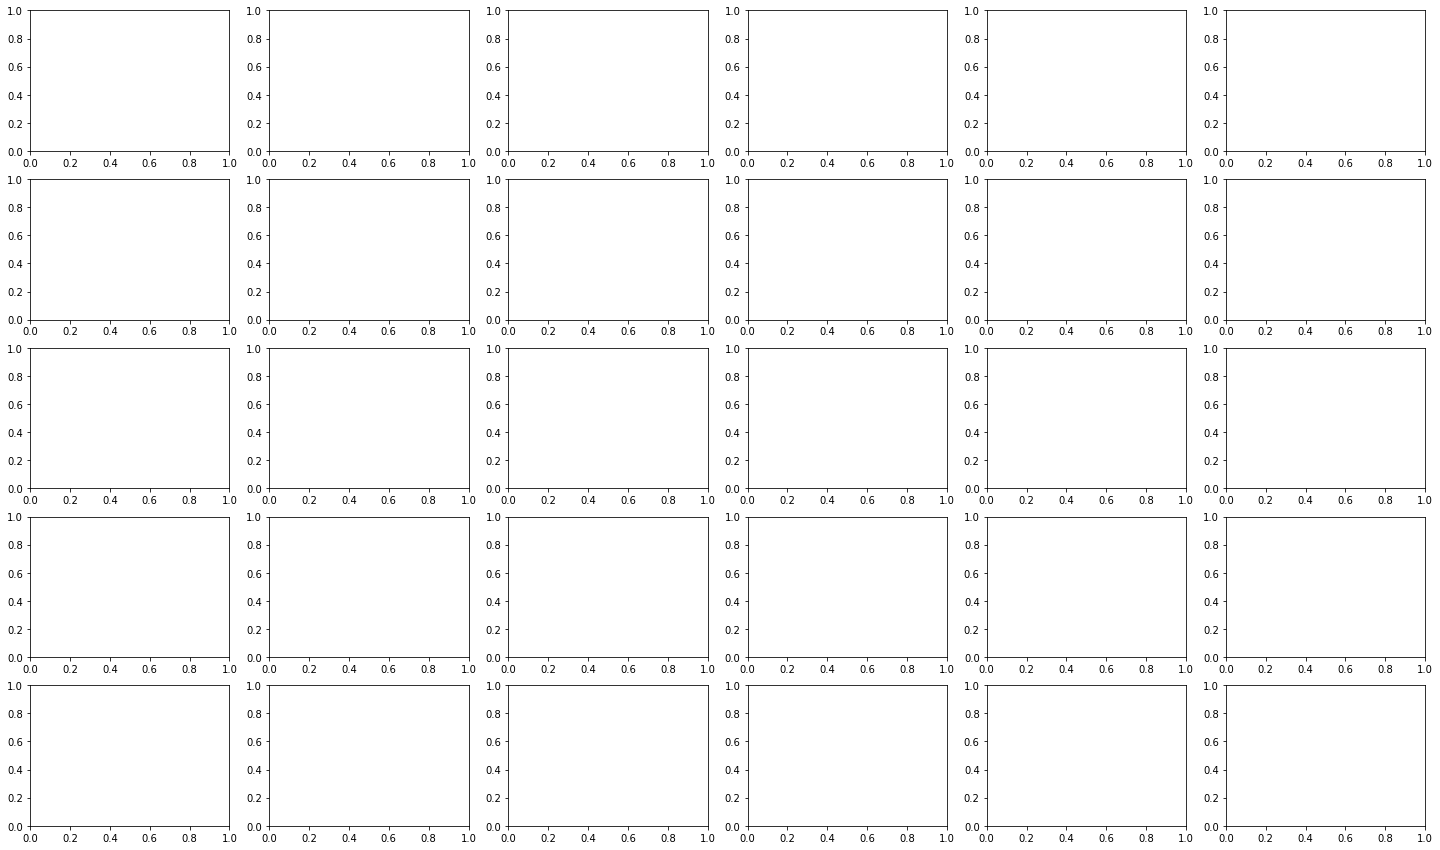

In [391]:
fig, ax = plt.subplots(5,6,figsize=(25,15))

In [392]:
flatax = ax.flatten()

In [393]:
seapal = sns.color_palette()
for i,cancer in tqdm(enumerate(cancer_to_keep)):
    std_meth = pd.read_csv(os.path.join(std_dir,cancer+"_std_km.csv")).set_index("Composite Element REF")

    sns.kdeplot(data=std_meth, x="std", hue="membership", shade="fill",ax=flatax[i], palette={"Low mode": seapal[0], "High mode": seapal[1]})
    sns.kdeplot(data=std_meth, x="std", color="red", label="Full density",ax=flatax[i])
    flatax[i].set_xlabel("std")
    flatax[i].set_title(cancer+" standard deviation density")
    flatax[i].set_xlim([-0.01,0.4])

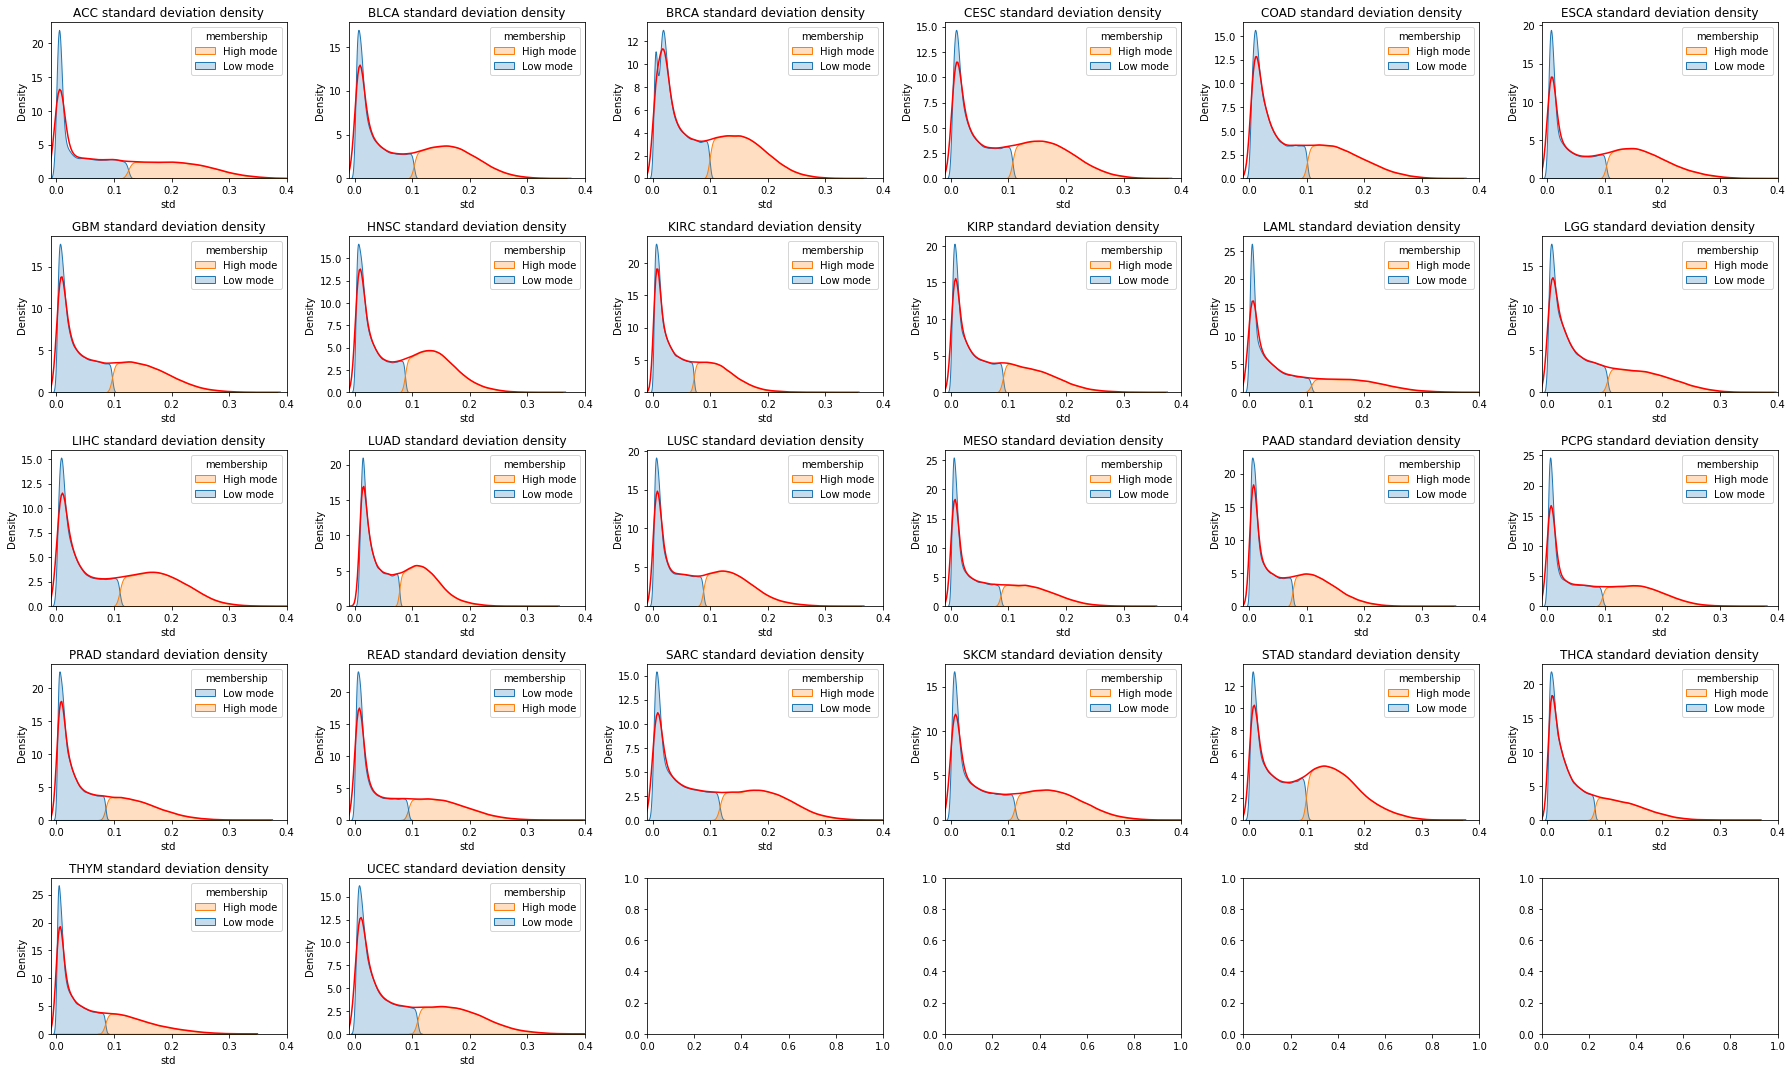

In [394]:
fig.tight_layout()
fig

In [395]:
flatax[-4].axis("off")
flatax[-3].axis("off")
flatax[-2].axis("off")
flatax[-1].axis("off")

(0.0, 1.0, 0.0, 1.0)

In [396]:
fig.savefig("std_density_km.png",dpi=100,bbox_inches="tight")
fig.savefig("std_density_km.svg",dpi=100,bbox_inches="tight")

In [400]:
for cancer in tqdm(cancer_to_keep):
    std_meth = pd.read_csv(os.path.join(std_dir,cancer+"_std_km.csv")).set_index("Composite Element REF")
    ind_keep = np.where(std_meth["membership"]=="High mode")[0]
    std_meth_filtered = std_meth.iloc[ind_keep]
    filtered_meth_data_pc[cancer] = filtered_meth_data_pc[cancer][list(std_meth_filtered.index)]

## Step 3. Purity correction

To perform purity correction we use: 
1. debCAM method: Chen L, Wu CT, Wang N, Herrington DM, Clarke R, Wang Y. debCAM: a bioconductor R package for fully unsupervised deconvolution of complex tissues. Bioinformatics. 2020 Jun 1;36(12):3927-3929. doi: 10.1093/bioinformatics/btaa205. PMID: 32219387; PMCID: PMC7320609.
2. Approximation inspired from swCAM: Chen L, Wu C-T, Lin C-H, et al. swCAM: estimation of subtype-specific expressions in individual samples with unsupervised sample-wise deconvolution. biorXiv, March 2021

debCAM with known mixing parameters is equivalent to using NNLS on X = AS to find S

In [100]:
from scipy.optimize import nnls

In [129]:
nnls_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\NNLS_estimates"
second_filter_perc, second_filter_size = [],[]
for i,cancer in tqdm(enumerate(cancer_to_keep)):
    Sest =pd.read_csv(os.path.join(nnls_dir,cancer+"_Sest.csv"))
    size = Sest.shape[0]
    init_size = size_450k - first_filter_size[i]
    remaining = init_size - size
    second_filter_size.append(remaining)
    perc = np.round((remaining/size_450k)*100)
    second_filter_perc.append(perc)

In [130]:
second_filter_perc

[32.0,
 29.0,
 29.0,
 28.0,
 31.0,
 28.0,
 31.0,
 28.0,
 32.0,
 32.0,
 36.0,
 33.0,
 28.0,
 28.0,
 29.0,
 33.0,
 30.0,
 31.0,
 34.0,
 32.0,
 29.0,
 28.0,
 25.0,
 35.0,
 35.0,
 31.0]

In [ ]:
nnls_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\NNLS_estimates"
purity_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\purity_corrected_meth"
purity_corrected_meth_data_pc = {}

avg_perc_clipped_probes = {}
avg_pos_probes = {}
avg_neg_probes = {}
for cancer in tqdm(cancer_to_keep):
    # get the list of normal patients to remove them from the purity correction
    normal_pat = []
    pat_list = np.array(filtered_meth_data_pc[cancer].index)
    for pat in pat_list:
        if pat.split("-")[-1]=='11' or pat.split("-")[-1]=='03':
            normal_pat.append(pat)
    
    # get the purity estimates and remove duplicates
    if cancer in cancer_estimate_purity:
        common_pat = filtered_meth_data_pc[cancer].index.intersection(estimate_purity.index)
        common_pat = common_pat[~common_pat.duplicated()]
        y = estimate_purity.loc[common_pat]
        y = y["TumorPurity"].astype(float)
    else:
        common_pat = filtered_meth_data_pc[cancer].index.intersection(purity.index)
        common_pat = common_pat[~common_pat.duplicated()]
        y = purity.loc[common_pat]["CPE"]
    
    # the mixing matrix A is (purity, 1-purity) for each patient
    A = pd.concat([y,y.apply(lambda x: 1-x)],axis=1)
    A.columns = ["cancer","infiltrate"]
    
    # remove the normal patients from the analysis
    X = filtered_meth_data_pc[cancer].drop(normal_pat)
    A = A.drop(A.index.intersection(normal_pat))
    # ensure we get the right order/patients, X is the observation matrix
    merged_X = X.merge(A,left_index=True,right_index=True,how="left")
    
    # get the array for A and X and remove the nan patients from the correction
    A_arr = merged_X[["cancer","infiltrate"]].values
    X_arr = merged_X.drop(["cancer","infiltrate"],axis=1).values
    ind_nan = np.unique(np.where(np.isnan(A_arr))[0])
    ind_non_nan = np.unique(np.where(~np.isnan(A_arr))[0])
    patients_na = merged_X.index[ind_nan]
    A_arr = A_arr[ind_non_nan]
    X_arr = X_arr[ind_non_nan]
    
    # for each probe, perform NNLS to estimate the S matrix (subtype specific expression for that probe)
    cg_val = []
    for i in tqdm(range(len(X.columns))):
        cg_val.append(nnls(A_arr,X_arr[:,i])[0])
    
    # clip to [0,1] interval to fit constraints
    S = pd.DataFrame(np.clip(np.array(cg_val),0,1),index=filtered_meth_data_pc[cancer].columns)
    
    # save the estimate substype specific matrix and mixing matrx S and A
    S.to_csv(os.path.join(nnls_dir,cancer+"_Sest.csv"))
    pd.DataFrame(A_arr,index=merged_X.index[ind_non_nan],columns=["cancer","infiltrate"]).to_csv(os.path.join(nnls_dir,cancer+"_Aest.csv"))
    
    # compute the number of clipped values for cancerous probes and infiltrate probes
    diff_index = np.where((np.clip(np.array(cg_val),0,1)[:,0]-np.array(cg_val)[:,0])!=0)[0]
    print(cancer,"clipped cancer probes %:",np.round(len(diff_index)/S.shape[0],3)*100,"(",len(diff_index),")")
    if len(diff_index)>0:
        print("mean: {}, min: {}, max: {}".format(np.array(cg_val)[:,0][diff_index].mean(),np.array(cg_val)[:,0][diff_index].min(),np.array(cg_val)[:,0][diff_index].max()))
    
    avg_perc_clipped_probes[cancer]=[np.round(len(diff_index)/S.shape[0],3)*100]
    avg_pos_probes[cancer]=[np.array(cg_val)[:,0][diff_index].mean()]
    
    diff_index = np.where((np.clip(np.array(cg_val),0,1)[:,1]-np.array(cg_val)[:,1])!=0)[0]
    print(cancer,"clipped infiltrate probes %:",np.round(len(diff_index)/S.shape[0],3)*100,"(",len(diff_index),")")
    if len(diff_index)>0:
        print("mean: {}, min: {}, max: {}".format(np.array(cg_val)[:,1][diff_index].mean(),np.array(cg_val)[:,1][diff_index].min(),np.array(cg_val)[:,1][diff_index].max()))
    avg_neg_probes[cancer]=[0]
    
    # compute the individual matrix using the approximation (see methods in the paper)
    indS = (X_arr - np.dot(A_arr[:,1].reshape(-1,1),S[1].values.reshape(1,-1)))
    indS = indS/A_arr[:,0].reshape(-1,1)
    S_df = pd.DataFrame(indS,index=merged_X.index[ind_non_nan],columns=S.index)
    S_df = pd.concat([S_df,filtered_meth_data_pc[cancer].loc[patients_na],filtered_meth_data_pc[cancer].loc[normal_pat]])
    
    # compute statistics on the clipped probes
    df = (S_df - S_df.clip(0,1))
    n=S_df.shape[0]*S_df.shape[1]
    
    neg_df = df.where(df<0,0)
    diff_index = np.where(neg_df!=0)
    print(cancer,"% clipped neg probes : ",np.round(len(diff_index[0])/n,3)*100)
    print("Mean neg : {}".format(neg_df.sum().sum()/len(diff_index[0])))
    
    avg_perc_clipped_probes[cancer].append(np.round(len(diff_index[0])/n,3)*100)
    
    pos_df = df.where(df>0,0)
    diff_index = np.where(pos_df!=0)
    print(cancer,"% clipped pos probes : ",np.round(len(diff_index[0])/n,3)*100)
    print("Mean pos : {}".format(1+pos_df.sum().sum()/len(diff_index[0])))   
    
    avg_perc_clipped_probes[cancer].append(np.round(len(diff_index[0])/n,3)*100)
    
    avg_pos_probes[cancer].append(1+pos_df.sum().sum()/len(diff_index[0]))
    avg_neg_probes[cancer].append(neg_df.sum().sum()/len(diff_index[0]))
    
    # clip the individual corrected methylation matrix 
    S_df.clip(0,1,inplace=True)
    purity_corrected_meth_data_pc[cancer]=S_df
    S_df.to_csv(os.path.join(purity_dir,cancer+"_meth_filtered_CAM.csv"))

Next we plot the evolution of standard deviation before and after purity correction

In [21]:
pur_corr_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\purity_corrected_meth"
purity_corrected_meth_data_pc = {}
for cancer in tqdm(cancer_to_keep):
    purity_corrected_meth_data_pc[cancer] = pd.read_csv(os.path.join(pur_corr_dir,cancer+"_meth_filtered_CAM.csv")).set_index("Unnamed: 0")

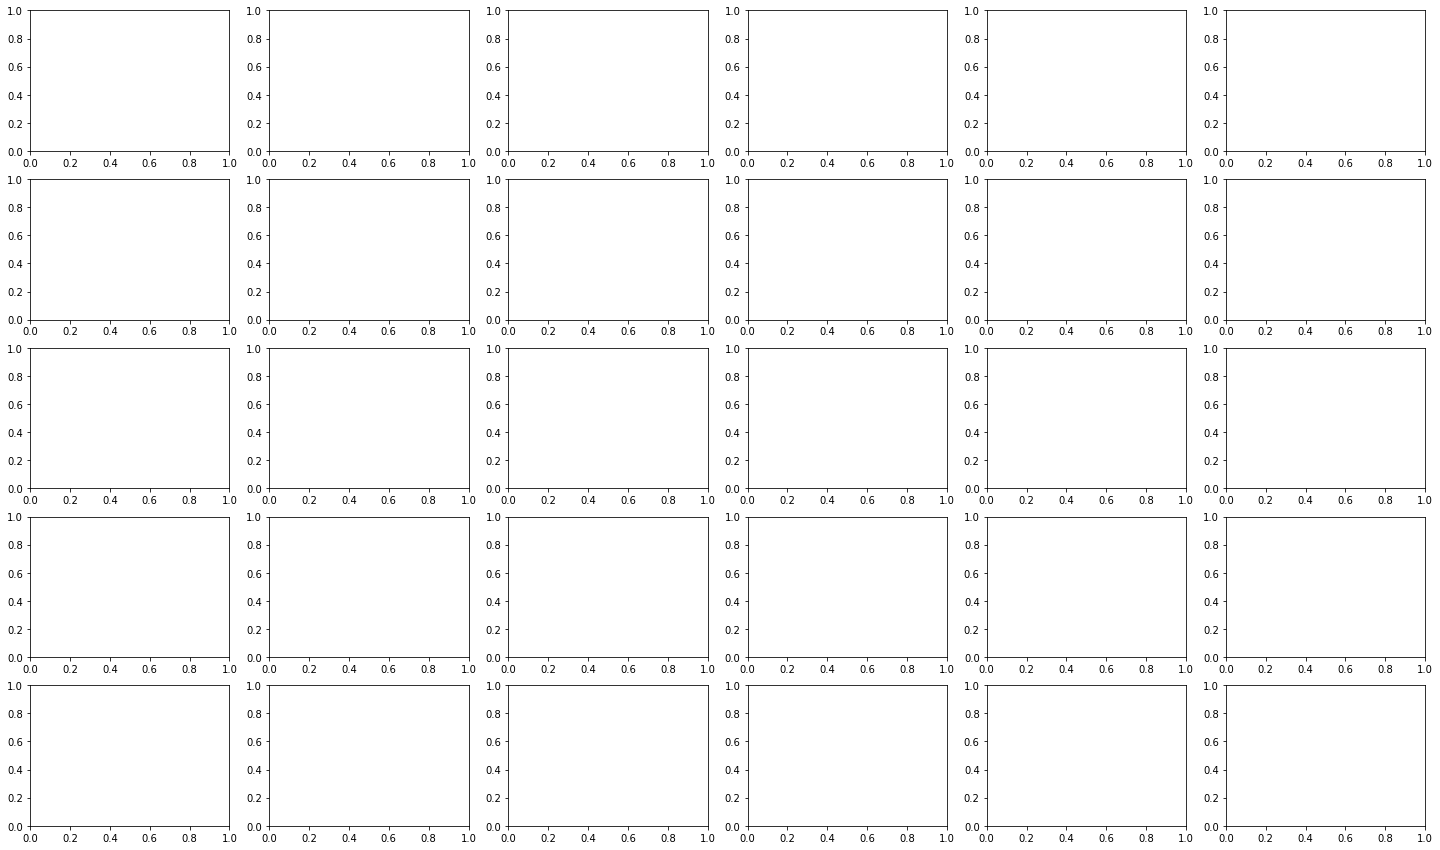

In [402]:
fig, ax = plt.subplots(5,6,figsize=(25,15))
flatax = ax.flatten()

In [403]:
for i,cancer in tqdm(enumerate(cancer_to_keep)):

    std_meth = pd.read_csv(os.path.join(std_dir,cancer+"_std_km.csv")).set_index("Composite Element REF")
    
    sns.kdeplot(data=std_meth, x="std", color="red", label="Full density",ax=flatax[i],common_norm=True)
    
    std_meth_pur =  purity_corrected_meth_data_pc[cancer].std()
    std_meth_pur = pd.concat([std_meth_pur,pd.DataFrame(["Purity corr"]*std_meth_pur.shape[0],columns=["membership"],index=std_meth_pur.index)],axis=1)
    std_meth_pur.columns = ["std","membership"]
    
    std_meth = pd.concat([std_meth,std_meth_pur])
    
    sns.kdeplot(data=std_meth, x="std", hue="membership",ax=flatax[i],common_norm=True)
    
    flatax[i].set_title(cancer+" std after purity corr",fontsize=15)
    flatax[i].set_xlim([-0.01,0.4])

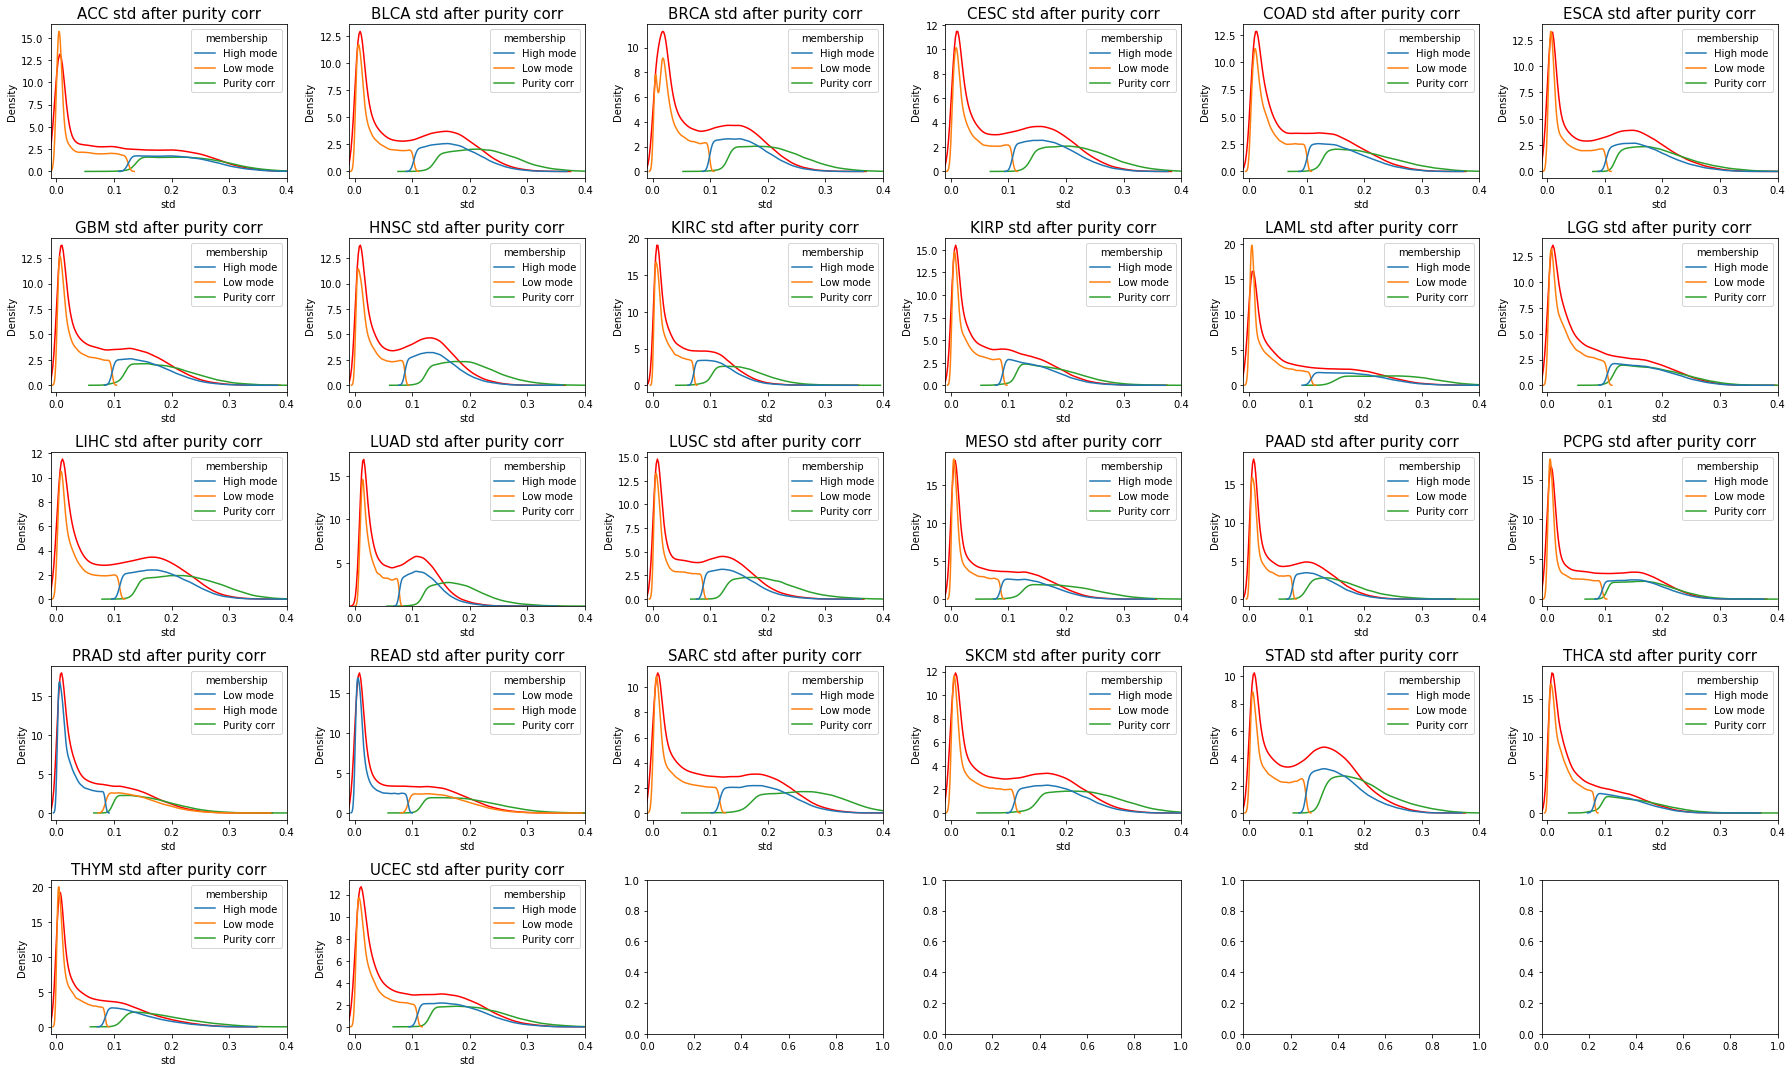

In [404]:
fig.tight_layout()
fig

In [405]:
flatax[-4].axis("off")
flatax[-3].axis("off")
flatax[-2].axis("off")
flatax[-1].axis("off")

(0.0, 1.0, 0.0, 1.0)

In [407]:
fig.savefig("std_after_pur_correction.svg",bbox_inches="tight")
fig.savefig("std_after_pur_correction.png",bbox_inches="tight")

### Plotting function

In [26]:
for cancer in tqdm(filtered_meth_data_pc):
    filtered_meth_data_pc[cancer] = filtered_meth_data_pc[cancer][purity_corrected_meth_data_pc[cancer].columns]

In [27]:
import umap

In [13]:
filtered_meth_data_pc = {}
filtered_dir = 'C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\meth_filter_1\\'
for cancer in tqdm(cancer_to_keep):
#     filtered_meth_data_pc[cancer].to_csv(os.path.join(filtered_dir,cancer+'_meth_filtered.csv'))
    filtered_meth_data_pc[cancer] = pd.read_csv(os.path.join(filtered_dir,cancer+'_meth_filtered.csv')).set_index("Unnamed: 0")

This section allows to plot the comparison UMAP of 
1. Before/after purity correction
2. Before/after age-related probes filtering

One must uncomment the relevant zones:
1. We want umap_red_data to be for filtered_meth_data_pc and umap_red_data_transf to be for purity_corrected_meth_data_pc
2. We want umap_red_data to be for purity_corrected_meth_data_pc and umap_red_data_transf to be for purity_corrected_meth_data_pc with cg_to_exclude dropped out

In [65]:
# umap_red_data,umap_red_data_transf = {},{}
for cancer in tqdm(cancer_to_keep):
    reducer = umap.UMAP()
#     umap_red_data[cancer] = reducer.fit_transform(filtered_meth_data_pc[cancer])
#     umap_red_data[cancer] = reducer.fit_transform(purity_corrected_meth_data_pc[cancer])
    umap_red_data[cancer] = umap_red_data_transf[cancer]
    
    reducer = umap.UMAP()
### after purity correction
#     umap_red_data_transf[cancer] = reducer.fit_transform(purity_corrected_meth_data_pc[cancer])
### after age correction
    cgl = purity_corrected_meth_data_pc[cancer].columns.intersection(cg_to_exclude)
    meth_data = purity_corrected_meth_data_pc[cancer].drop(cgl,axis=1)
    umap_red_data_transf[cancer] = reducer.fit_transform(meth_data)

In [66]:
for cancer in tqdm(cancer_to_keep):
#     umap_red_data[cancer] = pd.DataFrame(umap_red_data[cancer],index=filtered_meth_data_pc[cancer].index)
    umap_red_data[cancer] = pd.DataFrame(umap_red_data[cancer],index=purity_corrected_meth_data_pc[cancer].index)
    umap_red_data_transf[cancer] = pd.DataFrame(umap_red_data_transf[cancer],index=purity_corrected_meth_data_pc[cancer].index)

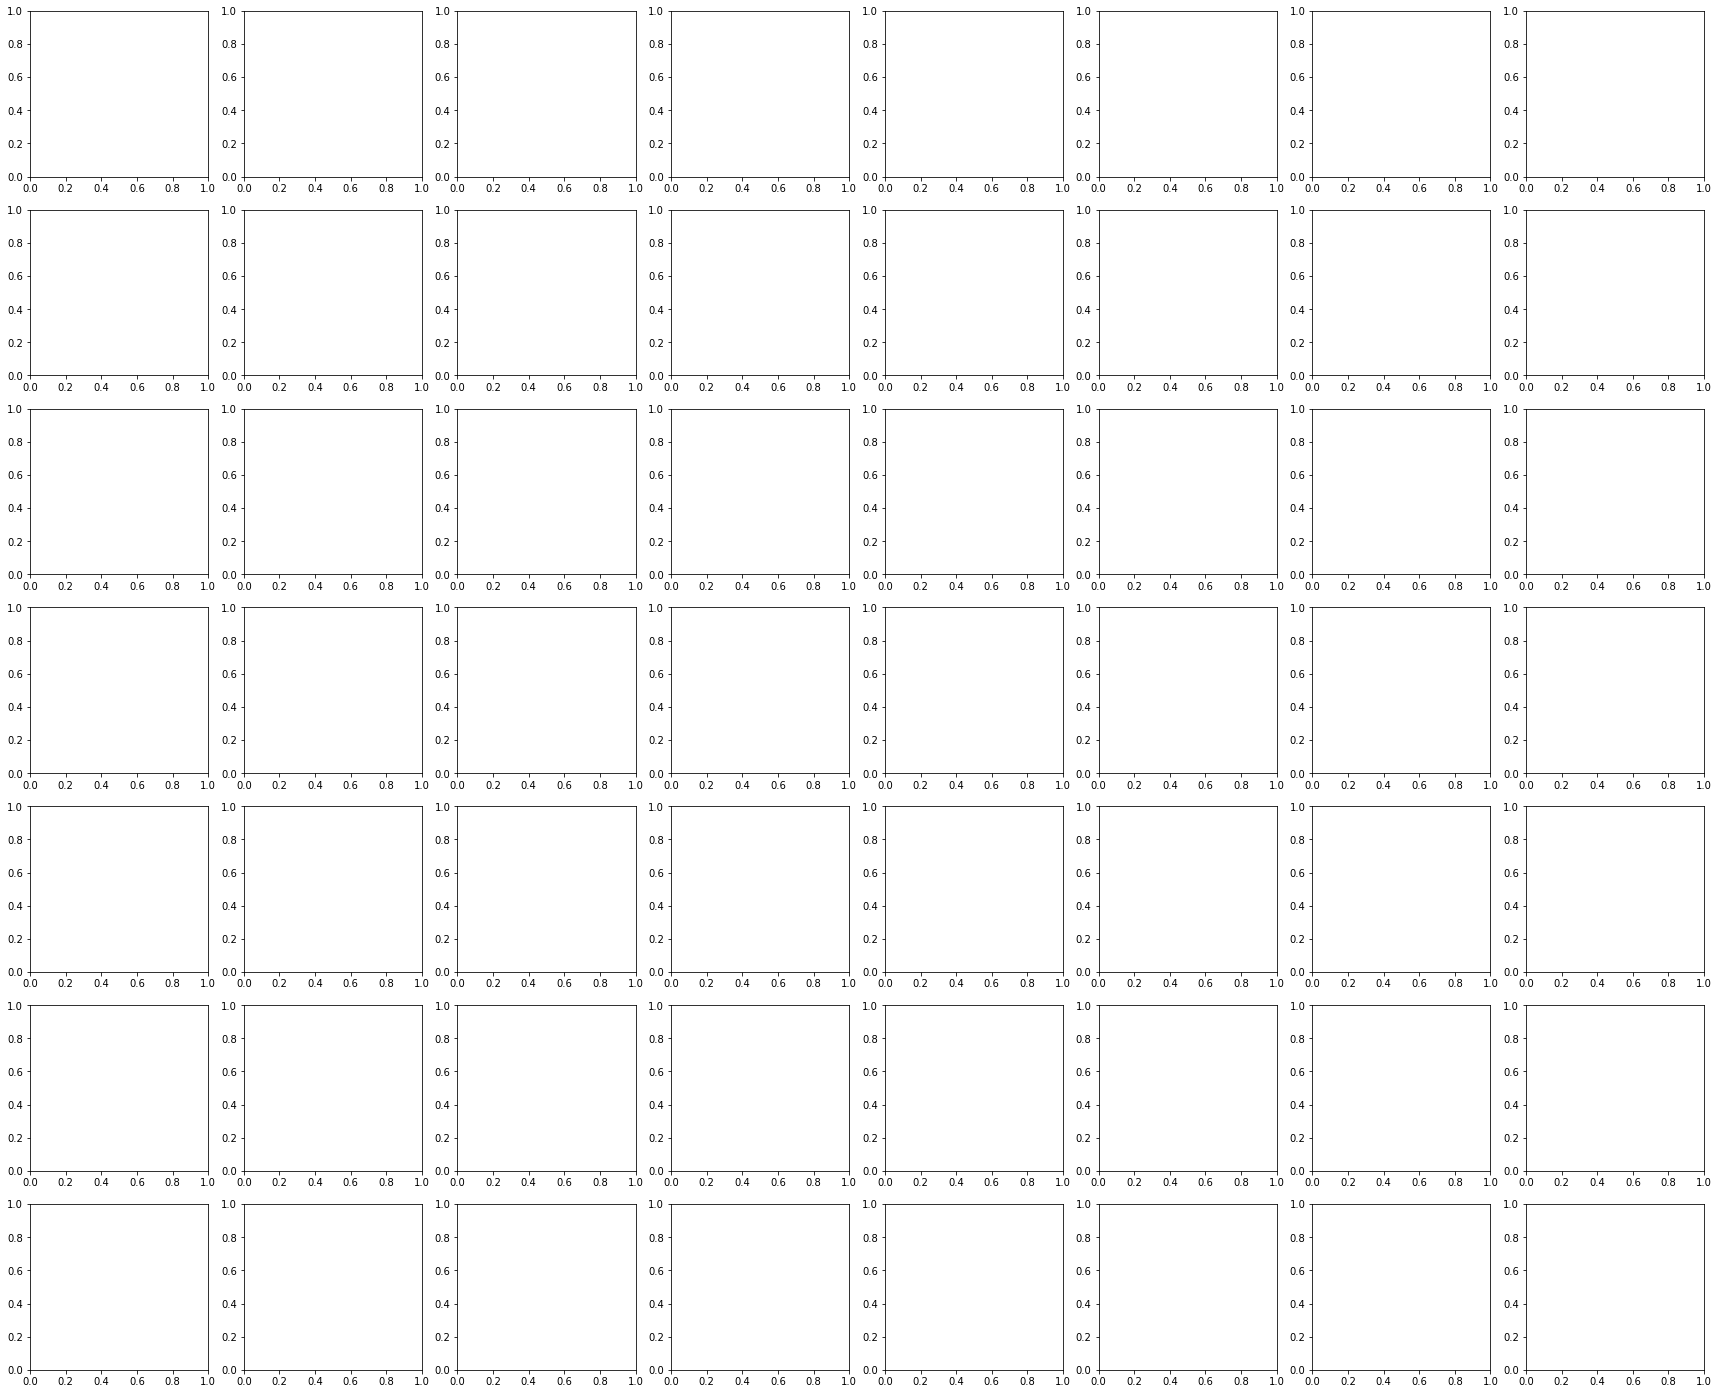

In [77]:
fig, ax = plt.subplots(7,8,figsize=(30,25))
flatax= ax.flatten()

In [78]:
figcount = 0
for cancer in tqdm(cancer_to_keep):
## for purity related    
#     if cancer in cancer_estimate_purity:
#         common_pat = filtered_meth_data_pc[cancer].index.intersection(estimate_purity.index)
#         common_pat = common_pat[~common_pat.duplicated()]
#         y = estimate_purity.loc[common_pat]
#         y = y["TumorPurity"].astype(float)
#     else:
#         common_pat = filtered_meth_data_pc[cancer].index.intersection(purity.index)
#         common_pat = common_pat[~common_pat.duplicated()]
#         y = purity.loc[common_pat]["CPE"]
    
## for age related
    # break the age into 10 bins for each cancer type
    y = pd.cut(-clin_data_pc[cancer]["age"],10,labels=["0-10","10-20","20-30","30-40","40-50","50-60","60-70","70-80","80-90","90-100"])
    
    normal_pat = []
    pat_list = np.array(filtered_meth_data_pc[cancer].index)
    for pat in pat_list:
        if pat.split("-")[-1]=='11':
            normal_pat.append(pat.split)
    print(cancer)
    y=y.drop(y.index.intersection(normal_pat))
    umap_red_pd = umap_red_data[cancer].drop(umap_red_data[cancer].index.intersection(normal_pat))
    umap_red_pd_transf = umap_red_data_transf[cancer].drop(umap_red_data_transf[cancer].index.intersection(normal_pat))
    
    umap_red_pd = umap_red_pd.merge(y,how="left",left_index=True,right_index=True)

### purity related
#     umap_red_pd.columns = ["Comp1","Comp2","Purity"]
### age related
    umap_red_pd.columns = ["Comp1","Comp2","Age"]

    
### purity related
#     sns.scatterplot(data=umap_red_pd,x="Comp1",y="Comp2",hue="Purity",ax=flatax[figcount],palette = sns.color_palette("flare", as_cmap=True))
### age related
    sns.scatterplot(data=umap_red_pd,x="Comp1",y="Comp2",hue="Age",ax=flatax[figcount],palette=sns.color_palette("rocket",n_colors=10))
    
    umap_red_pd = umap_red_pd_transf.merge(y,how="left",left_index=True,right_index=True)
    
### purity related
#     umap_red_pd.columns = ["Comp1","Comp2","Purity"]
### age related
    umap_red_pd.columns = ["Comp1","Comp2","Age"]

### purity related
#     sns.scatterplot(data=umap_red_pd,x="Comp1",y="Comp2",hue="Purity",ax=flatax[figcount+1],palette = sns.color_palette("flare", as_cmap=True))
### age related
    sns.scatterplot(data=umap_red_pd,x="Comp1",y="Comp2",hue="Age",ax=flatax[figcount+1],palette=sns.color_palette("rocket",n_colors=10))

### purity related
#     flatax[figcount].set_title(cancer+" uncorrected",fontsize=20)
### age related
    flatax[figcount].set_title(cancer+" purity corrected",fontsize=20)
    flatax[figcount].get_legend().remove()
### purity related
#     flatax[figcount+1].set_title(cancer+" purity corrected",fontsize=20)
### age related
    flatax[figcount+1].set_title(cancer+" age filtered",fontsize=20)
    flatax[figcount+1].get_legend().remove()
    figcount+=2

ACC
BLCA
BRCA
CESC
COAD
ESCA
GBM
HNSC
KIRC
KIRP
LAML
LGG
LIHC
LUAD
LUSC
MESO
PAAD
PCPG
PRAD
READ
SARC
SKCM
STAD
THCA
THYM
UCEC



In [79]:
handles, labels = flatax[4].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right',bbox_to_anchor=(4, 0.3), title="Age percentile",
           bbox_transform=plt.gcf().transFigure,fontsize=15, markerscale=3,frameon=False,ncol=3)
flatax[-1].axis("off")
flatax[-2].axis("off")
flatax[-3].axis("off")
flatax[-4].axis("off")

(0.0, 1.0, 0.0, 1.0)

<Figure size 432x288 with 0 Axes>

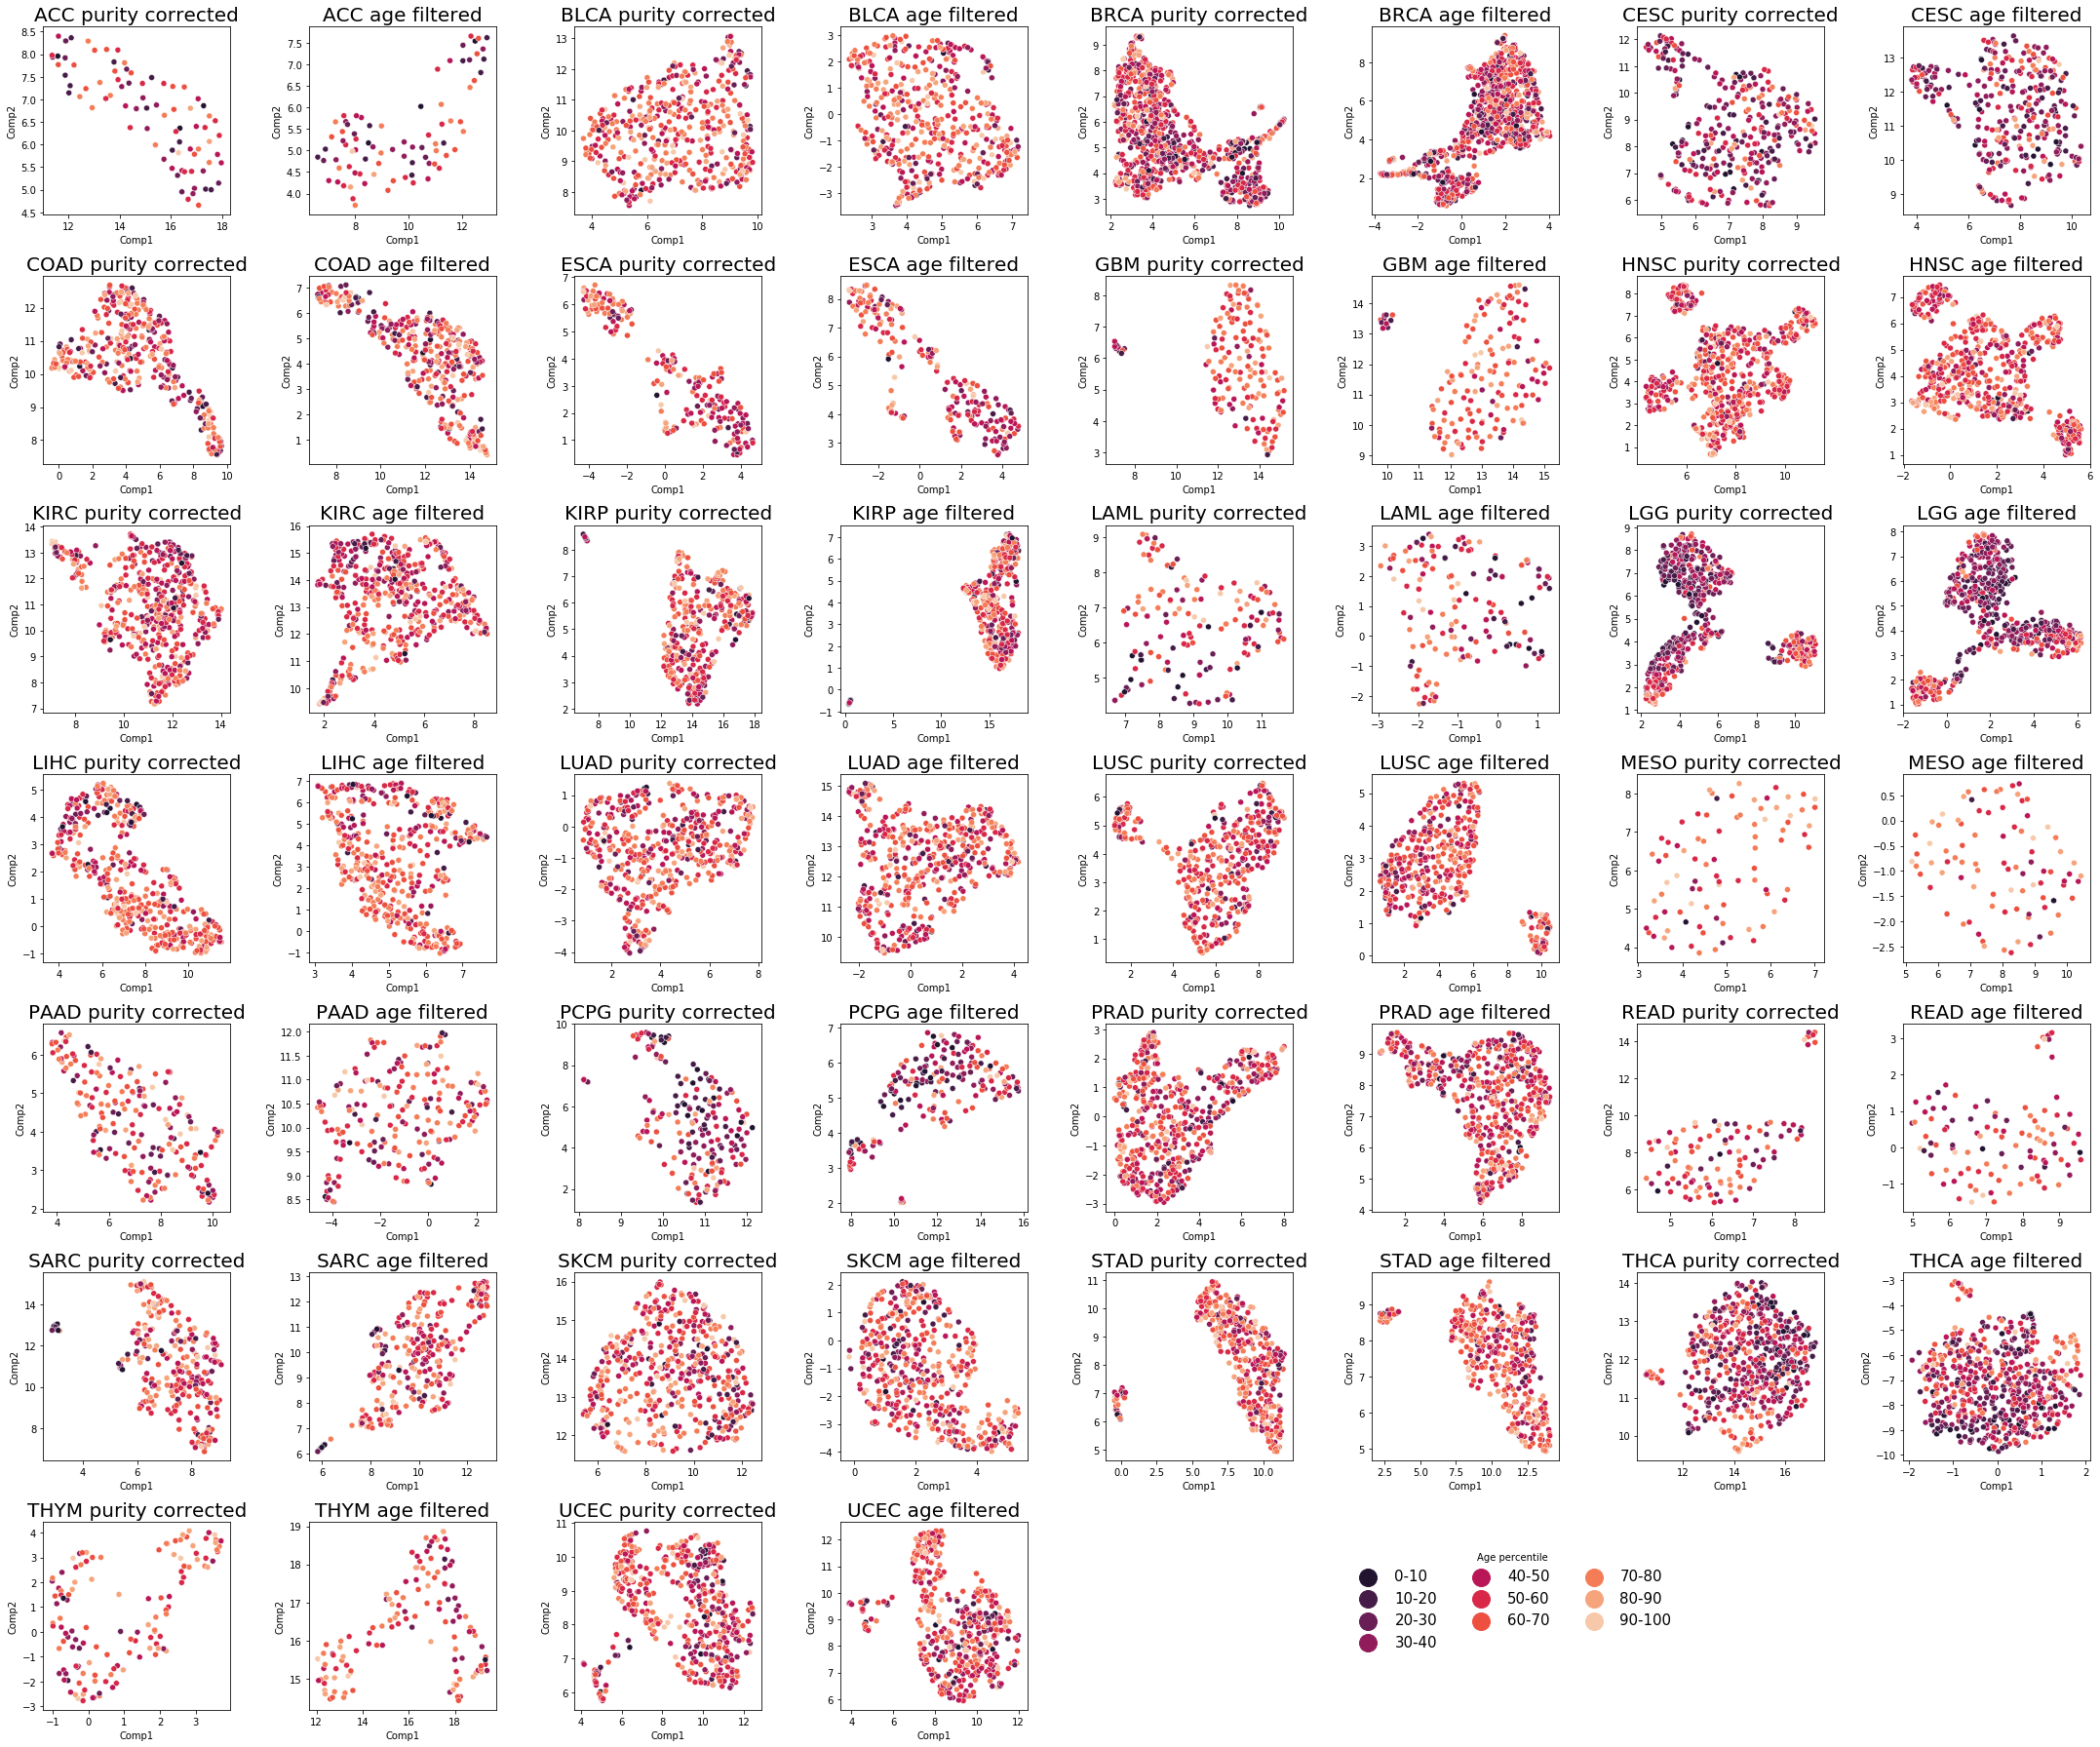

In [80]:
fig.tight_layout()
fig

In [81]:
# fig.savefig("umap_purity_corrected.png",bbox_inches="tight")
# fig.savefig("umap_purity_corrected.svg",bbox_inches="tight")
fig.savefig("umap_pur_age_corrected.png",bbox_inches="tight")
fig.savefig("umap_pur_age_corrected.svg",bbox_inches="tight")

## Step 4. Age related

First upload the CpG that have been associated in paper "Age‑related DNA methylation changes are tissue‑specific with ELOVL2 promoter methylation as exception", Slieker et al. 2018

aDMP: age-related differentially methylated position 

In [58]:
# directory containing the associated gain and loss methylations per tissue as a .txt file
# admp_dir = "/mnt/data/projects/Josephine_CIMP/CIMP_unsupervised_cancer/cpg_filtering/aDMP"
admp_dir = "N:\\data\\projects\\Josephine_CIMP\\CIMP_unsupervised_cancer\\cpg_filtering_Slieker\\aDMP"

In [59]:
# tissue_aDMP is a dictionary containing the tissue as key and the list of cpg IDs associated aDMP for each tissue as value

tissue_aDMP = {}
all_aDMP = []

for admp in os.listdir(admp_dir):
    tissue_name = admp.split("_")[0]
    
    if tissue_name not in tissue_aDMP.keys():
        tissue_aDMP[tissue_name]=[]
        
    file = os.path.join(admp_dir,admp)
    
    with open(file) as f:
        lines= f.readlines()
        for cg in lines:
            tissue_aDMP[tissue_name].append(cg.split("\n")[0])
            all_aDMP.append(cg.split("\n")[0])
            
for tissue in list(tissue_aDMP.keys()):
    tissue_aDMP[tissue] = np.array(tissue_aDMP[tissue])
all_aDMP = np.array(all_aDMP)

In [60]:
# tissue_aDMP now contains the gain/loss aDMP for all tissues studied in the 2018 paper
tissue_aDMP.keys()

dict_keys(['buccal', 'DLPFC', 'kidney', 'liver', 'monocytes', 'SAT', 'Thcell', 'wholeblood'])

Then compute age-related probes for each cancer type

In [432]:
age_r_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\age_r"
for cancer in tqdm(cancer_to_keep):
    
    filtered_meth_data = purity_corrected_meth_data_pc[cancer]
    
    # Slieker et al.
    cg_to_exclude = [cg for cg in all_aDMP if cg in filtered_meth_data.columns]
    filtered_meth_data = filtered_meth_data.drop(cg_to_exclude,axis=1)
    
    common_pat = filtered_meth_data.index.intersection(clin_data_pc[cancer].index)
    common_pat = common_pat[~common_pat.duplicated()]
    df1 = filtered_meth_data.loc[common_pat]
    df2 = -clin_data_pc[cancer].loc[common_pat]["age"]
    df1 = df1[~df1.index.duplicated()]
    df2 = df2[~df2.index.duplicated()]
    age_filtered_meth_data = pd.concat([df1,df2],axis=1,join="inner").dropna()
    y = age_filtered_meth_data["age"].values.ravel()

    r_scores,p_values = [],[]
    for cpg in tqdm(age_filtered_meth_data.columns[:-1]):
        x = age_filtered_meth_data[cpg].values.ravel()
        r,p = pearsonr(x,y)
        r_scores.append(r)
        p_values.append(p)
    r_scores = np.array(r_scores)
    p_values = np.array(p_values)
    
    q_values = ~multipletests(p_values,method="fdr_bh",alpha=0.05)[0]
    ind_nsign = np.where(q_values)[0]
    
    pd.DataFrame(r_scores.reshape(-1,1),index=filtered_meth_data.columns).to_csv(os.path.join(age_r_dir,cancer+"_age_r_purcorr.csv"))
    pd.DataFrame(p_values.reshape(-1,1),index=filtered_meth_data.columns).to_csv(os.path.join(age_r_dir,cancer+"_age_p_purcorr.csv"))

In [131]:
fourth_filter_size = [67002,75278,73339,74651,67027,78618,67081,73842,64597,66433,55617,56756,72731,74307,72635,65815,71100,
                      61644,61332,65970,69337,71906,79934,49787,57572,67121]

In [132]:
fourth_filter_perc = np.round(np.array(fourth_filter_size)/size_450k,2)*100

In [ ]:
first_filter_perc.append(np.array(first_filter_perc).mean())
second_filter_perc.append(np.array(second_filter_perc).mean())
fourth_filter_perc = np.append(fourth_filter_perc,np.array(fourth_filter_perc).mean())

In [145]:
remaining_perc = []
for i in range(len(cancer_to_keep)+1):
    remaining_perc.append(100-first_filter_perc[i]-second_filter_perc[i]-fourth_filter_perc[i])

In [156]:
plot_df = pd.DataFrame([first_filter_perc,second_filter_perc,fourth_filter_perc,remaining_perc],columns=cancer_to_keep+["Average"],index=["First filter", "Second filter", "Third filter","Remaining probes"])

In [158]:
plot_df = plot_df.round().astype(int)

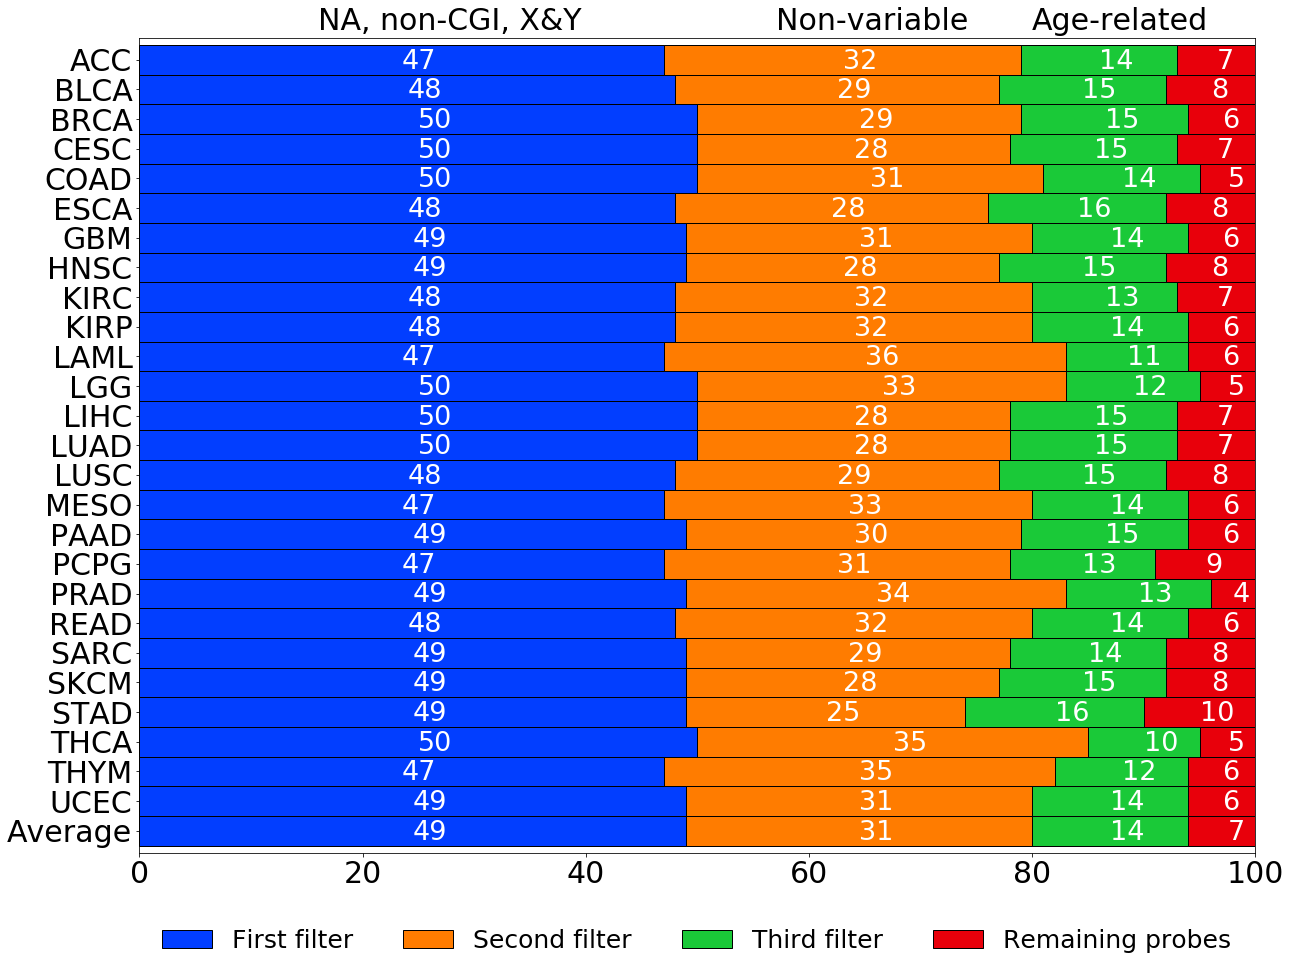

In [207]:
fig,ax = plt.subplots(1,1,figsize=(20,15))
plot_df.T.plot(kind="barh",stacked=True,ax=ax,legend=False,width=1,color=sns.color_palette("bright"),edgecolor="black")
ax.set_xlim([0,100])
ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)

values = plot_df.T.values.flatten("F")

plt.gca().invert_yaxis()

for i, p in enumerate(ax.patches):
    ax.annotate(str(values[i]), xy=(p.get_x()+ values[i]/2, p.get_y()+0.8),size=27,color="white")


plt.legend(bbox_to_anchor=(0, -0.15), loc=3, ncol=4, prop={'size': 25}, frameon=False)

ax.text(16,-1,"NA, non-CGI, X&Y",size=30)
ax.text(57,-1,"Non-variable",size=30)
ax.text(80,-1,"Age-related",size=30)

fig.savefig("filter_effect_main.png",bbox_inches="tight")
fig.savefig("filter_effect_main.svg",bbox_inches="tight")

In [61]:
# get the age related cpg for each cancer type
age_r_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\age_r"
age_rel_cg_pc = {}
for cancer in tqdm(cancer_to_keep):
    
    age_r = pd.read_csv(os.path.join(age_r_dir,cancer+"_age_r_purcorr.csv")).set_index("Composite Element REF")
    pval = pd.read_csv(os.path.join(age_r_dir,cancer+"_age_p_purcorr.csv")).set_index("Composite Element REF")

    r_scores = age_r.values.ravel()
    p_values = pval.values.ravel()
    q_values = multipletests(p_values,method="fdr_bh",alpha=0.05)[0]
    ind_sign = np.where(q_values)[0]
#     ind_sign = np.where(p_values<0.05)[0]
    age_rel_cg_pc[cancer]=np.array((purity_corrected_meth_data_pc[cancer][age_r.index].columns)[ind_sign])

In [62]:
# find the cpg probes that are age-related in at least two cancer types
cg_to_exclude = []
for i,cancer1 in tqdm(enumerate(cancer_to_keep)):
    for j,cancer2 in tqdm(enumerate(cancer_to_keep[i+1:])):
        ar = list(np.intersect1d(age_rel_cg_pc[cancer1],age_rel_cg_pc[cancer2]))
        cg_to_exclude+=ar
        print(cancer1,cancer2,len(ar))
cg_to_exclude = np.unique(cg_to_exclude)

ACC BLCA 0
ACC BRCA 0
ACC CESC 0
ACC COAD 0
ACC ESCA 0
ACC GBM 0
ACC HNSC 0
ACC KIRC 0
ACC KIRP 0
ACC LAML 0
ACC LGG 0
ACC LIHC 0
ACC LUAD 0
ACC LUSC 0
ACC MESO 0
ACC PAAD 0
ACC PCPG 0
ACC PRAD 0
ACC READ 0
ACC SARC 0
ACC SKCM 0
ACC STAD 0
ACC THCA 0
ACC THYM 0
ACC UCEC 0



BLCA BRCA 36
BLCA CESC 2
BLCA COAD 6
BLCA ESCA 43
BLCA GBM 9
BLCA HNSC 9
BLCA KIRC 2
BLCA KIRP 6
BLCA LAML 8
BLCA LGG 53
BLCA LIHC 37
BLCA LUAD 3
BLCA LUSC 5
BLCA MESO 0
BLCA PAAD 0
BLCA PCPG 4
BLCA PRAD 4
BLCA READ 0
BLCA SARC 3
BLCA SKCM 8
BLCA STAD 28
BLCA THCA 17
BLCA THYM 50
BLCA UCEC 23



BRCA CESC 1435
BRCA COAD 7027
BRCA ESCA 10339
BRCA GBM 3175
BRCA HNSC 4064
BRCA KIRC 1017
BRCA KIRP 4496
BRCA LAML 3687
BRCA LGG 15468
BRCA LIHC 11073
BRCA LUAD 381
BRCA LUSC 914
BRCA MESO 0
BRCA PAAD 0
BRCA PCPG 333
BRCA PRAD 7261
BRCA READ 0
BRCA SARC 1915
BRCA SKCM 1982
BRCA STAD 2864
BRCA THCA 7569
BRCA THYM 6164
BRCA UCEC 5159



CESC COAD 530
CESC ESCA 1007
CESC GBM 252
CESC HNSC 498
CESC KIRC 80
CESC KIRP 396
CESC LAML 238
CESC LGG 1676
CESC LIHC 967
CESC LUAD 54
CESC LUSC 178
CESC MESO 0
CESC PAAD 0
CESC PCPG 57
CESC PRAD 471
CESC READ 0
CESC SARC 228
CESC SKCM 218
CESC STAD 445
CESC THCA 710
CESC THYM 1213
CESC UCEC 690



COAD ESCA 5508
COAD GBM 1123
COAD HNSC 2001
COAD KIRC 395
COAD KIRP 2117
COAD LAML 1662
COAD LGG 5119
COAD LIHC 4014
COAD LUAD 147
COAD LUSC 202
COAD MESO 0
COAD PAAD 0
COAD PCPG 36
COAD PRAD 2644
COAD READ 0
COAD SARC 313
COAD SKCM 740
COAD STAD 506
COAD THCA 2352
COAD THYM 1117
COAD UCEC 1367



ESCA GBM 2081
ESCA HNSC 2468
ESCA KIRC 486
ESCA KIRP 2977
ESCA LAML 2326
ESCA LGG 10757
ESCA LIHC 8081
ESCA LUAD 308
ESCA LUSC 1161
ESCA MESO 0
ESCA PAAD 0
ESCA PCPG 362
ESCA PRAD 3242
ESCA READ 0
ESCA SARC 1315
ESCA SKCM 1348
ESCA STAD 2645
ESCA THCA 4080
ESCA THYM 6893
ESCA UCEC 4195



GBM HNSC 834
GBM KIRC 283
GBM KIRP 1338
GBM LAML 779
GBM LGG 7513
GBM LIHC 2267
GBM LUAD 78
GBM LUSC 254
GBM MESO 0
GBM PAAD 0
GBM PCPG 67
GBM PRAD 1283
GBM READ 0
GBM SARC 401
GBM SKCM 624
GBM STAD 500
GBM THCA 1969
GBM THYM 1416
GBM UCEC 1018



HNSC KIRC 278
HNSC KIRP 1126
HNSC LAML 903
HNSC LGG 3572
HNSC LIHC 2313
HNSC LUAD 66
HNSC LUSC 342
HNSC MESO 0
HNSC PAAD 0
HNSC PCPG 43
HNSC PRAD 1695
HNSC READ 0
HNSC SARC 296
HNSC SKCM 387
HNSC STAD 424
HNSC THCA 1753
HNSC THYM 1203
HNSC UCEC 1118



KIRC KIRP 123
KIRC LAML 184
KIRC LGG 1095
KIRC LIHC 788
KIRC LUAD 53
KIRC LUSC 31
KIRC MESO 0
KIRC PAAD 0
KIRC PCPG 5
KIRC PRAD 422
KIRC READ 0
KIRC SARC 119
KIRC SKCM 195
KIRC STAD 161
KIRC THCA 932
KIRC THYM 391
KIRC UCEC 359



KIRP LAML 1009
KIRP LGG 4839
KIRP LIHC 2938
KIRP LUAD 110
KIRP LUSC 293
KIRP MESO 0
KIRP PAAD 0
KIRP PCPG 52
KIRP PRAD 2055
KIRP READ 0
KIRP SARC 299
KIRP SKCM 679
KIRP STAD 423
KIRP THCA 1114
KIRP THYM 1272
KIRP UCEC 1003



LAML LGG 2951
LAML LIHC 1899
LAML LUAD 57
LAML LUSC 81
LAML MESO 0
LAML PAAD 0
LAML PCPG 41
LAML PRAD 1331
LAML READ 0
LAML SARC 184
LAML SKCM 424
LAML STAD 414
LAML THCA 1136
LAML THYM 839
LAML UCEC 810



LGG LIHC 13643
LGG LUAD 409
LGG LUSC 1576
LGG MESO 0
LGG PAAD 0
LGG PCPG 639
LGG PRAD 5734
LGG READ 0
LGG SARC 2045
LGG SKCM 2608
LGG STAD 3908
LGG THCA 9701
LGG THYM 12203
LGG UCEC 7295



LIHC LUAD 323
LIHC LUSC 906
LIHC MESO 0
LIHC PAAD 0
LIHC PCPG 1324
LIHC PRAD 4289
LIHC READ 0
LIHC SARC 3392
LIHC SKCM 1487
LIHC STAD 4904
LIHC THCA 6220
LIHC THYM 7924
LIHC UCEC 8078



LUAD LUSC 41
LUAD MESO 0
LUAD PAAD 0
LUAD PCPG 10
LUAD PRAD 147
LUAD READ 0
LUAD SARC 28
LUAD SKCM 60
LUAD STAD 78
LUAD THCA 227
LUAD THYM 198
LUAD UCEC 110



LUSC MESO 0
LUSC PAAD 0
LUSC PCPG 61
LUSC PRAD 293
LUSC READ 0
LUSC SARC 192
LUSC SKCM 205
LUSC STAD 197
LUSC THCA 517
LUSC THYM 1332
LUSC UCEC 509



MESO PAAD 0
MESO PCPG 0
MESO PRAD 0
MESO READ 0
MESO SARC 0
MESO SKCM 0
MESO STAD 0
MESO THCA 0
MESO THYM 0
MESO UCEC 0



PAAD PCPG 0
PAAD PRAD 0
PAAD READ 0
PAAD SARC 0
PAAD SKCM 0
PAAD STAD 0
PAAD THCA 0
PAAD THYM 0
PAAD UCEC 0



PCPG PRAD 114
PCPG READ 0
PCPG SARC 256
PCPG SKCM 30
PCPG STAD 418
PCPG THCA 287
PCPG THYM 607
PCPG UCEC 460



PRAD READ 0
PRAD SARC 576
PRAD SKCM 767
PRAD STAD 889
PRAD THCA 2786
PRAD THYM 1320
PRAD UCEC 1672



READ SARC 0
READ SKCM 0
READ STAD 0
READ THCA 0
READ THYM 0
READ UCEC 0



SARC SKCM 273
SARC STAD 1086
SARC THCA 1343
SARC THYM 1678
SARC UCEC 1504



SKCM STAD 337
SKCM THCA 1166
SKCM THYM 1328
SKCM UCEC 765



STAD THCA 1893
STAD THYM 3794
STAD UCEC 2411



THCA THYM 4675
THCA UCEC 3348



THYM UCEC 5578



In [63]:
# this is the total number of CpG probes that were found in at least two cancer types
len(cg_to_exclude)

93438

In [438]:
# this is the number of CpG probes to remove for each cancer type (the intersection)
fourth_filter_count = []
for cancer in cancer_to_keep:
    ct = len(purity_corrected_meth_data_pc[cancer].columns.intersection(cg_to_exclude))
    fourth_filter_count.append(ct)
    print(cancer,ct)

ACC 67002
BLCA 75278
BRCA 73339
CESC 74651
COAD 67027
ESCA 78618
GBM 67081
HNSC 73842
KIRC 64597
KIRP 66433
LAML 55617
LGG 56756
LIHC 72731
LUAD 74307
LUSC 72635
MESO 65815
PAAD 71100
PCPG 61644
PRAD 61332
READ 65970
SARC 69337
SKCM 71906
STAD 79934
THCA 49787
THYM 57572
UCEC 67121


In [449]:
# Finally, save the methylation data with the age-related cpgs excluded
for cancer in tqdm(cancer_to_keep[11:]):
    cgl = purity_corrected_meth_data_pc[cancer].columns.intersection(cg_to_exclude)
    mdata = purity_corrected_meth_data_pc[cancer].drop(cgl,axis=1)
    print("Remaining probes {}: {}".format(cancer,mdata.shape[1]))
    mdata.to_csv('C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\filtered_new_method\\'+cancer+'_meth_filtered.csv')

Remaining probes LGG: 23685
Remaining probes LIHC: 34744
Remaining probes LUAD: 32428
Remaining probes LUSC: 37288
Remaining probes MESO: 31298
Remaining probes PAAD: 30624
Remaining probes PCPG: 41606
Remaining probes PRAD: 23476
Remaining probes READ: 29389
Remaining probes SARC: 35027
Remaining probes SKCM: 35655
Remaining probes STAD: 42899
Remaining probes THCA: 22522
Remaining probes THYM: 26972
Remaining probes UCEC: 28019



# Purity correction on simulated data

As proof of concept to convince ourselves the approximation derived from the swCAM paper works, we simulated artifical cancerous data by using
1. The purity for the LUSC or LUAD cancer type
2. A mixture of Gaussians with different std or means (sigma1/mu1 are for cancerous cells, mu2 are for infiltrate cells)

We then compute the evolution of std for the deconvoluted signal to confirm our observation, and compute the Mean Absolute Error between the "true" (ie simulated) cancerous cell signal and the deconvoluted one 

In [53]:
simu_purity = purity[purity["Cancer.type"]=="LUSC"]["CPE"]
# simu_purity = purity[purity["Cancer.type"]=="LUAD"]["CPE"]

Text(0.5, 0, 'sm 0.14, sd 0.19, MEm 0.11, MEd 0.02')

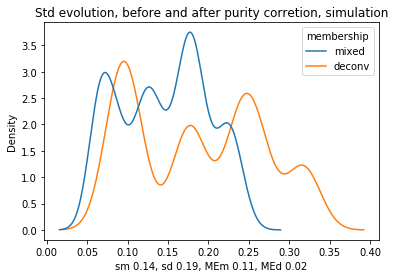

In [317]:
n_probes = 1000
sigma1_l = [0.1,0.25,0.4]
mu1_l = [0.1,0.4,0.6,0.9]
mu2_l = [0,0.25,0.5,0.75,1]


mu_pairs = []
for m in mu1_l:
    for n in mu2_l:
        mu_pairs.append([m,n])
# this is only to see how it would change were the distribution of mixtures not equiprobable
# mu_pairs.append([0.1, 0])
# mu_pairs.append([0.1, 0])
# mu_pairs.append([0.9, 1])
# mu_pairs.append([0.9, 1])

# select at random the parameters for each probe
chosen_features = []
for j in range(n_probes):
    sigma1 = np.random.choice(sigma1_l)
    mu1,mu2 = mu_pairs[np.random.randint(len(mu_pairs))]
    chosen_features.append([sigma1,mu1,mu2])

df_simu_meth,df_simu_meth_true = [],[]
for i in tqdm(range(simu_purity.shape[0])):
    # simulate for each patient
    simu_meth,simu_meth_true = [],[]
    # draw an observation for each probe using the randomly chosen parameters for the probe
    for j in range(n_probes):
        sigma1,mu1,mu2 = chosen_features[j]
        # clip to [0,1] so it respects the beta value constraints
        cancer_meth = np.clip(np.random.normal(mu1,sigma1),0,1)
        infiltrate_meth = np.clip(np.random.normal(mu2,0.05),0,1)
        # compute both the admixture and the "true" simulated signal
        simu_meth.append(simu_purity.iloc[i]*cancer_meth+(1-simu_purity.iloc[i])*infiltrate_meth)
        simu_meth_true.append(cancer_meth)
        
    if len(df_simu_meth)==0:
        df_simu_meth = pd.DataFrame(np.array(simu_meth).reshape(1,-1),index=[simu_purity.index[i]])
    else:
        df_simu_meth = pd.concat([df_simu_meth,pd.DataFrame(np.array(simu_meth).reshape(1,-1),index=[simu_purity.index[i]])])

    if len(df_simu_meth_true)==0:
        df_simu_meth_true = pd.DataFrame(np.array(simu_meth_true).reshape(1,-1),index=[simu_purity.index[i]])
    else:
        df_simu_meth_true = pd.concat([df_simu_meth_true,pd.DataFrame(np.array(simu_meth_true).reshape(1,-1),index=[simu_purity.index[i]])])

# create the mixing matrix
A = pd.concat([simu_purity,simu_purity.apply(lambda x: 1-x)],axis=1)
A.columns = ["cancer","infiltrate"]
# get the "observation" matrix
X = df_simu_meth
merged_X = X.merge(A,left_index=True,right_index=True,how="left")
A_arr = merged_X[["cancer","infiltrate"]].values
X_arr = merged_X.drop(["cancer","infiltrate"],axis=1).values

# perform NNLS for each probe
cg_val = []
for i in range(len(X.columns)):
    cg_val.append(nnls(A_arr,X_arr[:,i])[0])

# clip to fill the beta value constraints
S = pd.DataFrame(np.clip(np.array(cg_val),0,1))

# get the individual methylation matrix through approximation
indS = (X_arr - np.dot(A_arr[:,1].reshape(-1,1),S[1].values.reshape(1,-1)))
indS = indS/A_arr[:,0].reshape(-1,1)
S_df = pd.DataFrame(indS,index=merged_X.index,columns=S.index)

S_df.clip(0,1,inplace=True)

# get the standard deviation for the simulated mixture data and the deconvoluted data
std_mixed, std_deconv = df_simu_meth.std(),S_df.std()
# get the mean squared error between the simulated mixed data and the "true" cancerous cell signal as well as between
# the deconvoluted data and the "true" cancerous signal
ME_mixed, ME_deconv = (df_simu_meth-df_simu_meth_true).abs().mean(),(S_df-df_simu_meth_true).abs().mean()

# plot the evolution of std as well as the values for the average std and the mean absolute error
# (mixed (m) and deconvoluted (d))
mixed_df = pd.concat([std_mixed,pd.DataFrame(["mixed"]*std_mixed.shape[0])],axis=1)
deconv_df = pd.concat([std_deconv,pd.DataFrame(["deconv"]*std_deconv.shape[0])],axis=1)
full_std_df = pd.concat([mixed_df,deconv_df])
full_std_df.columns = ["std","membership"]
ax=sns.kdeplot(data=full_std_df,x="std",hue="membership",common_norm=True)
ax.set_title("Std evolution, before and after purity corretion, simulation")
ax.set_xlabel("sm {}, sd {}, MEm {}, MEd {}".format(np.round(std_mixed.mean(),2),np.round(std_deconv.mean(),2),np.round(ME_mixed.mean(),2),np.round(ME_deconv.mean(),2)))

To understand the effect on the std for each parameter pairs (eg cancerous cell methylated, infiltrate unmethylated, cancerous standard deviation 0.2 ?) we simulate each of these cases 100 times and plot the effect on the mean standard deviation of the mixed (resp deconvoluted) data and Mean Absolute Error of the mixed (resp deconvoluted) data

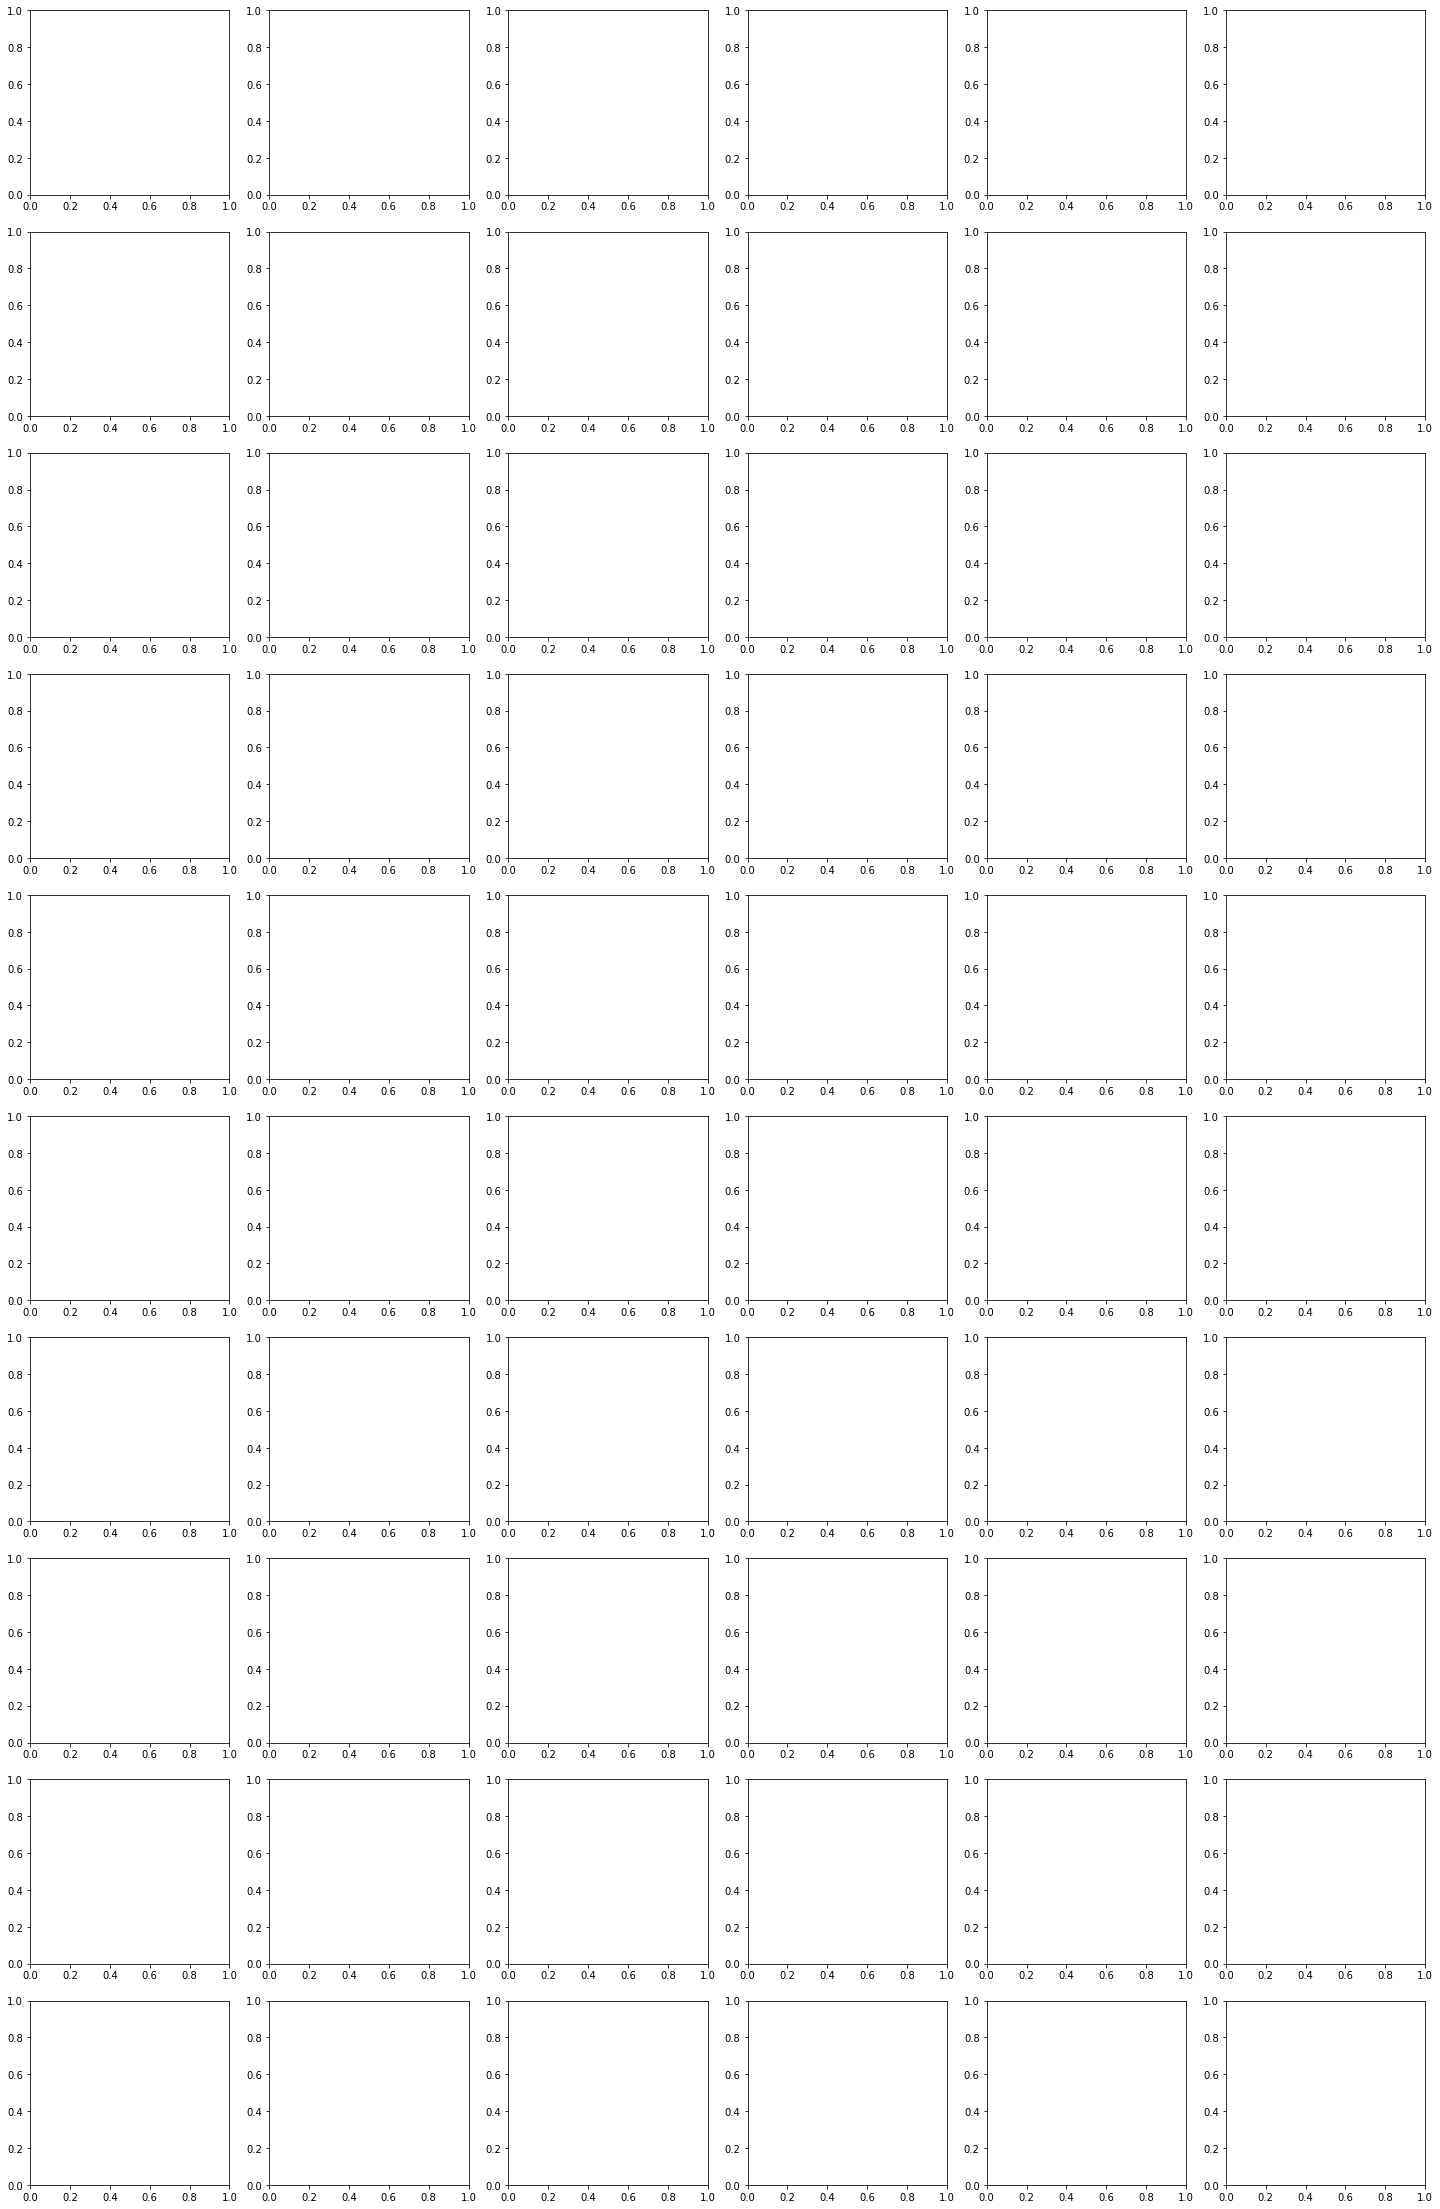

In [284]:
fig, ax = plt.subplots(10,6,figsize=(25,40))
flatax = ax.flatten()

In [285]:
fignum=0
for mu1 in tqdm([0,0.2,0.4,0.6,0.8,1]):
    for mu2 in [0,0.5,1]:
        for sigma1 in [0.15,0.25,0.4]:
            simu_meth = []
            for i in range(simu_purity.shape[0]):
                cancer_meth = np.clip(np.random.normal(mu1,sigma1),0,1)
                infiltrate_meth = np.clip(np.random.normal(mu2,0.05),0,1)
                simu_meth.append(simu_purity.iloc[i]*cancer_meth+(1-simu_purity.iloc[i])*infiltrate_meth)
            sns.histplot(data=simu_meth,ax=flatax[fignum],element="step",bins=20)
            flatax[fignum].set_title("mu1 {}, mu2 {}, sigma1 {}".format(mu1,mu2,sigma1),fontsize=15)
            flatax[fignum].set_xlim([0,1])
            fignum+=1

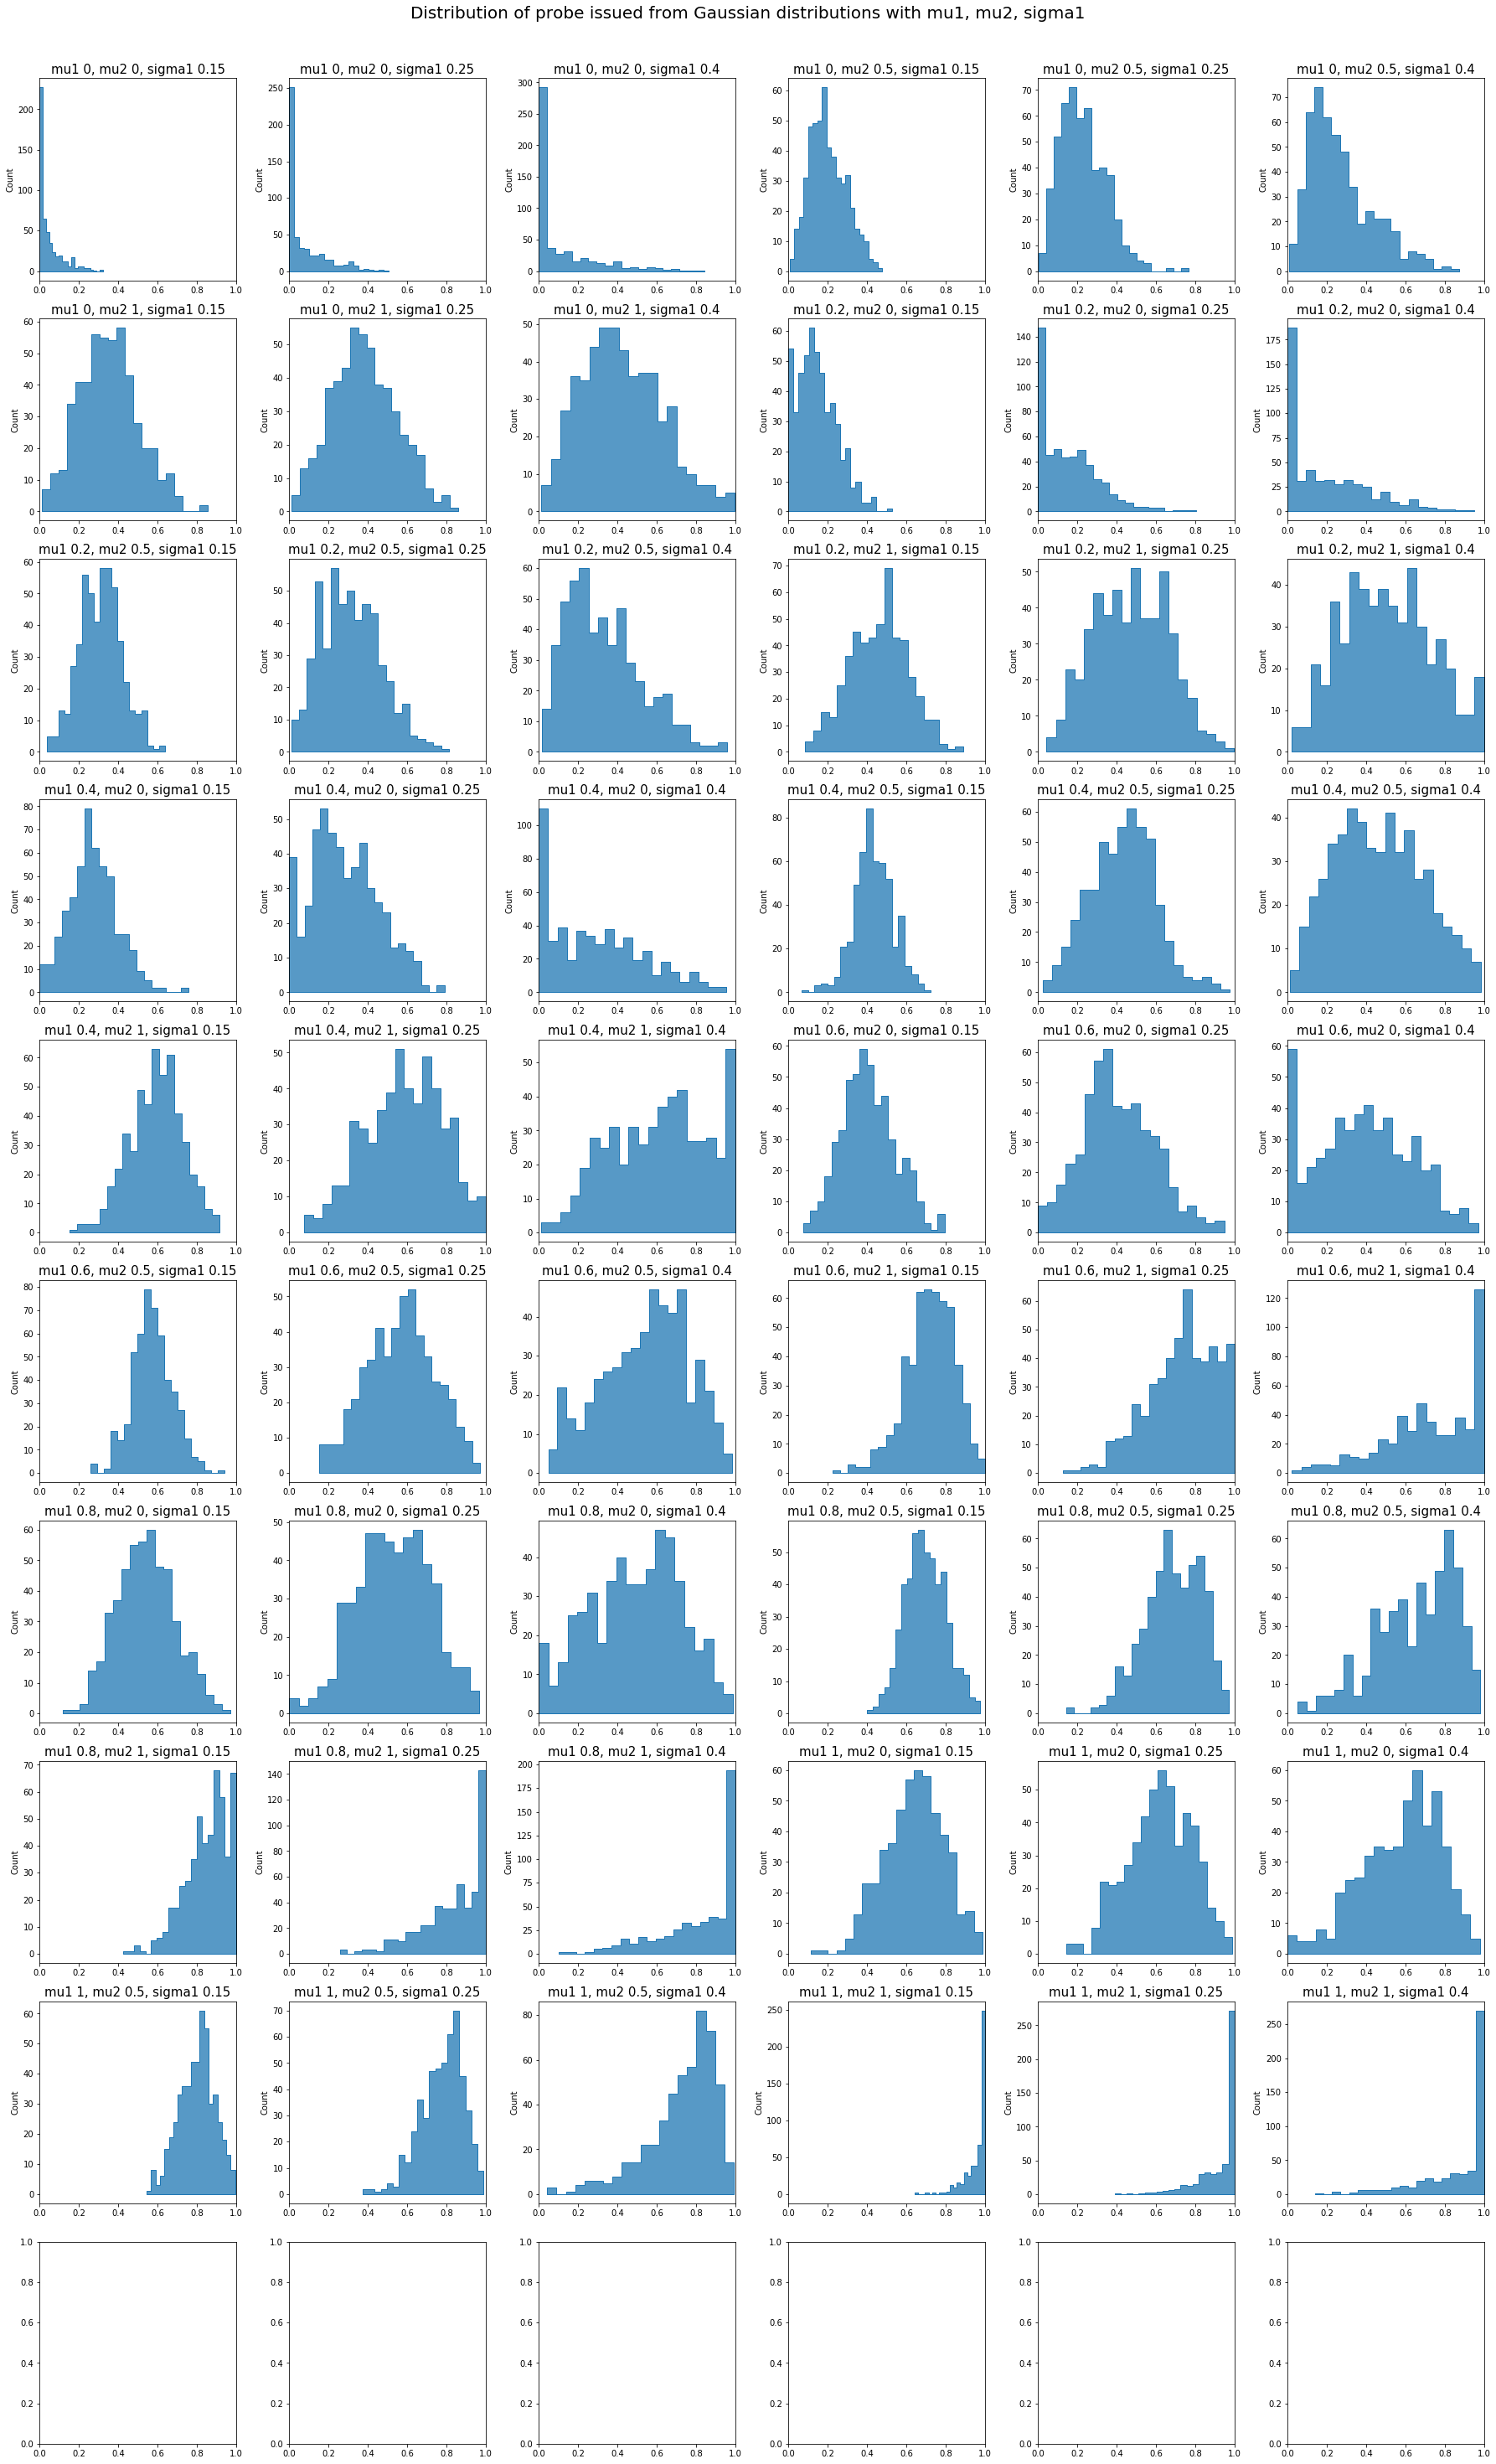

In [286]:
fig.suptitle("Distribution of probe issued from Gaussian distributions with mu1, mu2, sigma1 ",fontsize=20,y=1.02)
fig.tight_layout()
fig

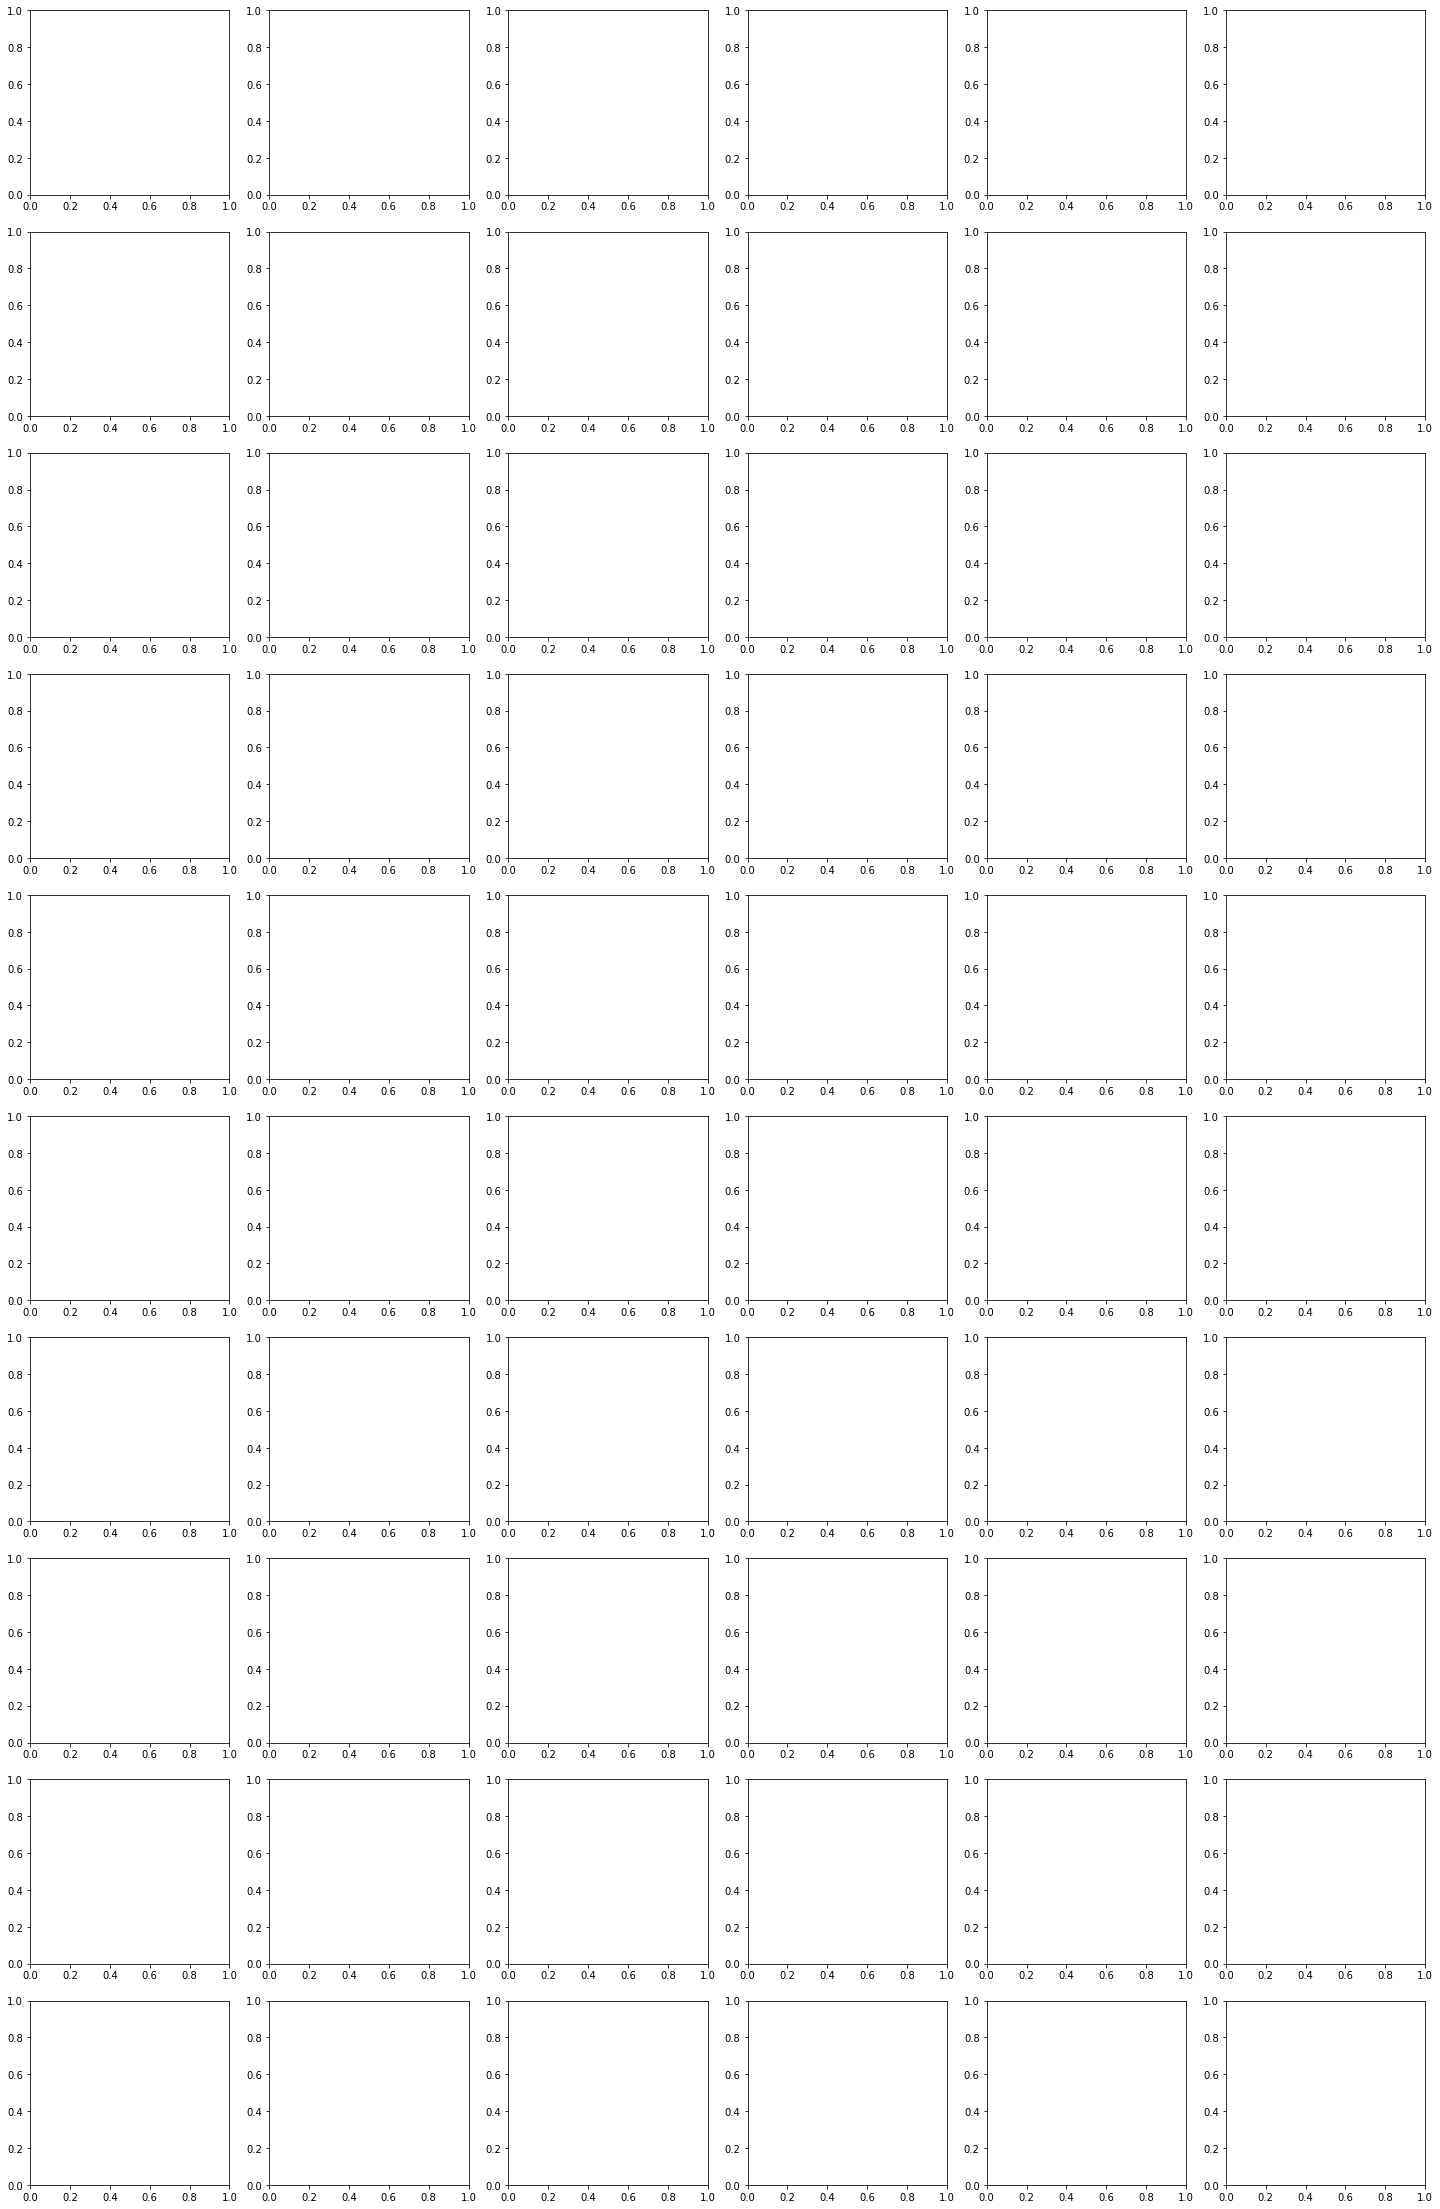

In [275]:
fig, ax = plt.subplots(10,6,figsize=(25,40))
flatax = ax.flatten()

In [276]:
# select 6 random probes for the true data to try to get representatitivy and tune the parameters
for i in range(60):
    probe = np.random.randint(filtered_meth_data_pc[cancer].shape[1])
    sns.histplot(data=filtered_meth_data_pc[cancer].iloc[:,probe],ax=flatax[i],element="step",bins=20)
    flatax[i].set_title("Probe {}".format(i),fontsize=15)
    flatax[i].set_xlim([0,1])

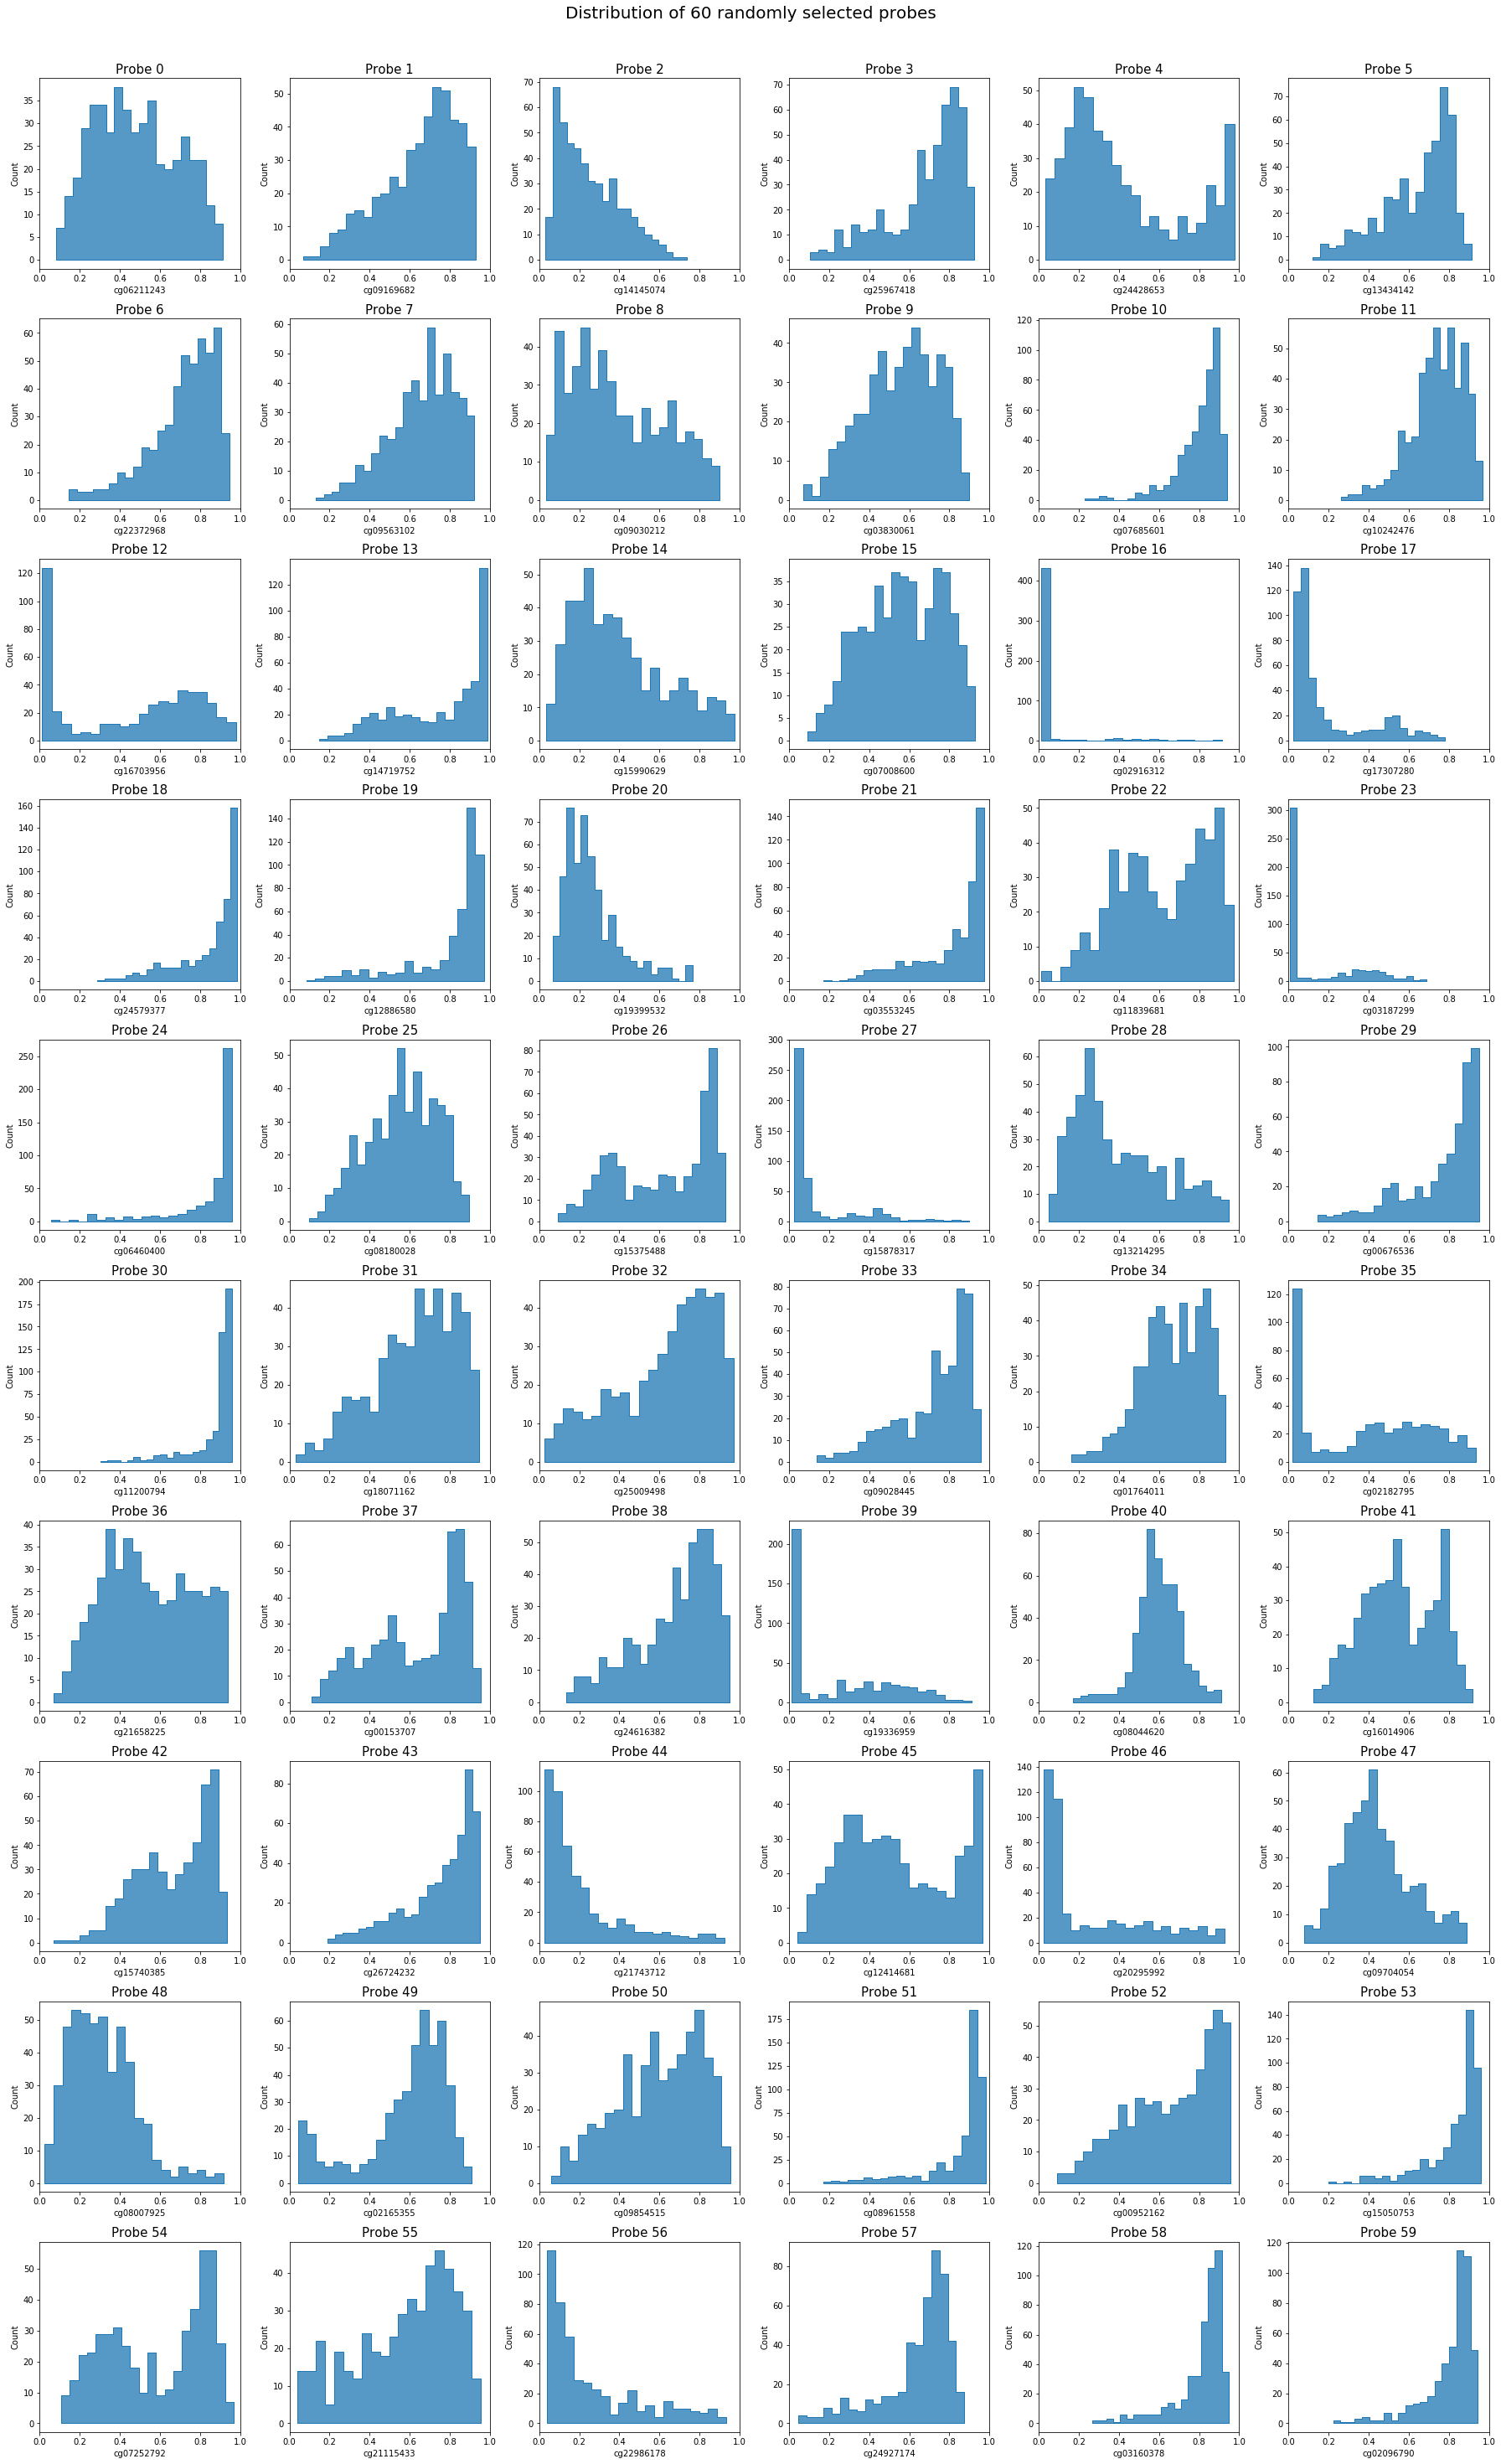

In [278]:
fig.suptitle("Distribution of 60 randomly selected probes",fontsize=20,y=1.02)
fig.tight_layout()
fig

In [ ]:
fignum=0
for mu1 in tqdm([0,0.33,0.66,1]):
    for mu2 in [0,0.25,0.5,0.75,1]:
        for sigma1 in [0.1,0.2,0.3]:
            df_simu_meth,df_simu_meth_true = [],[]
            for i in range(simu_purity.shape[0]):
                simu_meth,simu_meth_true = [],[]
                for j in range(100):
                    cancer_meth = np.clip(np.random.normal(mu1,sigma1),0,1)
                    infiltrate_meth = np.clip(np.random.normal(mu2,0.05),0,1)
                    simu_meth.append(simu_purity.iloc[i]*cancer_meth+(1-simu_purity.iloc[i])*infiltrate_meth)
                    simu_meth_true.append(cancer_meth)
                if len(df_simu_meth)==0:
                    df_simu_meth = pd.DataFrame(np.array(simu_meth).reshape(1,-1),index=[simu_purity.index[i]])
                else:
                    df_simu_meth = pd.concat([df_simu_meth,pd.DataFrame(np.array(simu_meth).reshape(1,-1),index=[simu_purity.index[i]])])

                if len(df_simu_meth_true)==0:
                    df_simu_meth_true = pd.DataFrame(np.array(simu_meth_true).reshape(1,-1),index=[simu_purity.index[i]])
                else:
                    df_simu_meth_true = pd.concat([df_simu_meth_true,pd.DataFrame(np.array(simu_meth_true).reshape(1,-1),index=[simu_purity.index[i]])])
                    
            A = pd.concat([simu_purity,simu_purity.apply(lambda x: 1-x)],axis=1)
            A.columns = ["cancer","infiltrate"]
            X = df_simu_meth
            merged_X = X.merge(A,left_index=True,right_index=True,how="left")
            A_arr = merged_X[["cancer","infiltrate"]].values
            X_arr = merged_X.drop(["cancer","infiltrate"],axis=1).values

            cg_val = []
            for i in range(len(X.columns)):
                cg_val.append(nnls(A_arr,X_arr[:,i])[0])

            S = pd.DataFrame(np.clip(np.array(cg_val),0,1))

            indS = (X_arr - np.dot(A_arr[:,1].reshape(-1,1),S[1].values.reshape(1,-1)))
            indS = indS/A_arr[:,0].reshape(-1,1)
            S_df = pd.DataFrame(indS,index=merged_X.index,columns=S.index)

            S_df.clip(0,1,inplace=True)

            std_mixed, std_deconv = df_simu_meth.std(),S_df.std()
            ME_mixed, ME_deconv = (df_simu_meth-df_simu_meth_true).abs().mean(),(S_df-df_simu_meth_true).abs().mean()

            mixed_df = pd.concat([std_mixed,pd.DataFrame(["mixed"]*std_mixed.shape[0])],axis=1)
            deconv_df = pd.concat([std_deconv,pd.DataFrame(["deconv"]*std_deconv.shape[0])],axis=1)
            full_std_df = pd.concat([mixed_df,deconv_df])
            full_std_df.columns = ["std","membership"]
            sns.kdeplot(data=full_std_df,x="std",hue="membership",common_norm=True,ax=flatax[fignum])

#                 flatax[fignum].text(flatax[fignum].get_xticks()[0],flatax[fignum].get_yticks()[-1],"Std mixed "+str(np.round(std_mixed.mean(),2)))
#                 flatax[fignum].text(flatax[fignum].get_xticks()[2],flatax[fignum].get_yticks()[-1],"Std deconv "+str(np.round(std_deconv.mean(),2)))
#                 flatax[fignum].text(flatax[fignum].get_xticks()[4],flatax[fignum].get_yticks()[-1],"ME mixed "+str(np.round(ME_mixed.mean(),2)))
#                 flatax[fignum].text(flatax[fignum].get_xticks()[6],flatax[fignum].get_yticks()[-1],"ME deconv "+str(np.round(ME_deconv.mean(),2)))
            flatax[fignum].set_title("mu1 {}, mu2 {}, std1 {}, std2 0.05".format(mu1,mu2,sigma1),fontsize=20)
            flatax[fignum].set_xlabel("sm {}, sd {}, MEm {}, MEd {}".format(np.round(std_mixed.mean(),2),np.round(std_deconv.mean(),2),np.round(ME_mixed.mean(),2),np.round(ME_deconv.mean(),2)),fontsize=20)
            fignum+=1

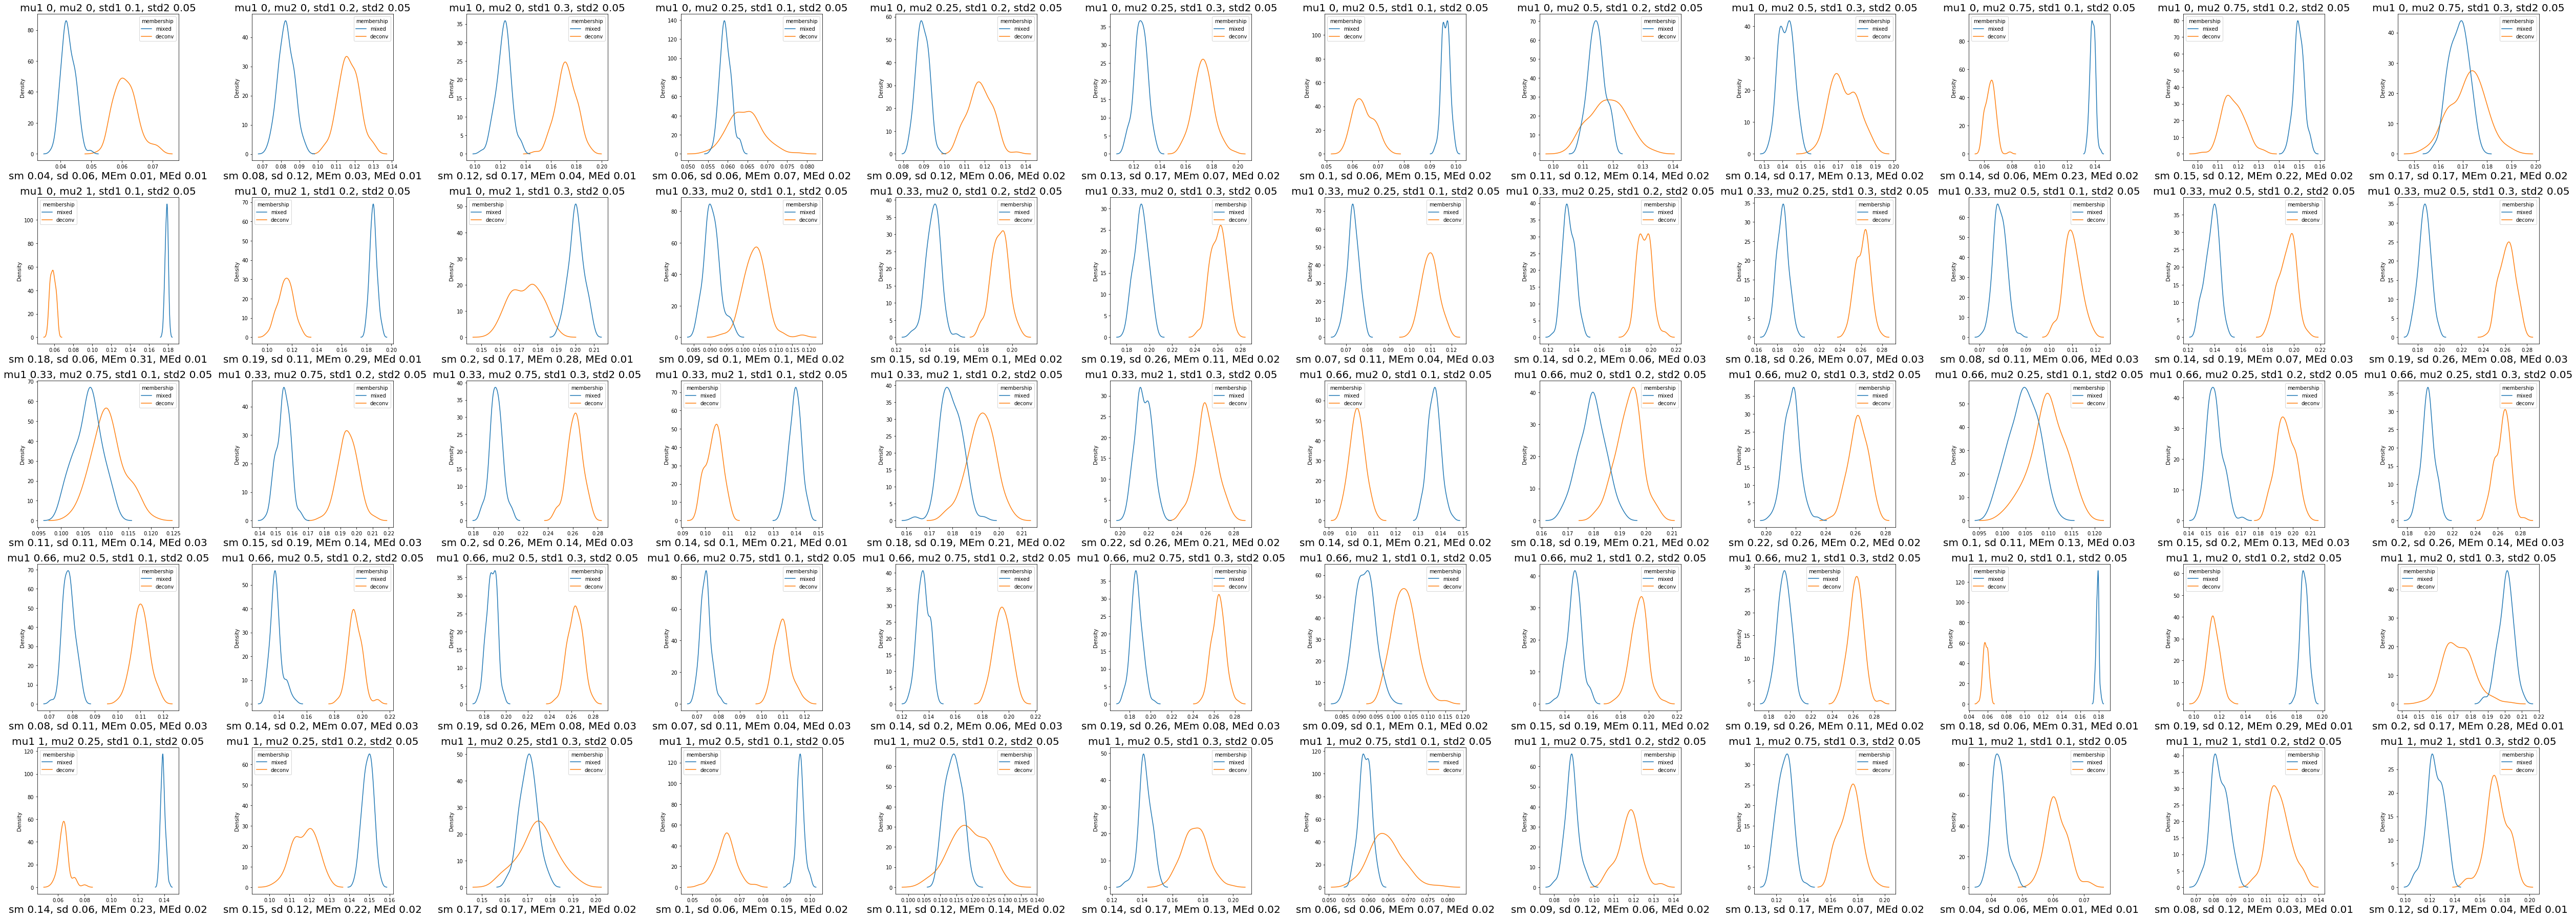

In [364]:
fig.tight_layout()
fig